목표 : 대기시간 예측
1. 가장 연관 있을 것 같은 변수들로 Input 값 구성하여 모델 구축
2. PCA 분석 (정규화 필수, 변수 자체는 의미가 없어질 수 있음)
3. 기존의 베이스라인을 이용하면 변수 중요도 분석 및 예측 모델 작성 가능

- ANN 모델에서 클래스 분류 모델을 이용할 수 있을까?
Output의 값이 연속적인 값으로 클래스가 아니긴 하지만 적당히 클래스를 구분하면 가능할 것도 같다는 생각. 또는 ANN 모델을 여러 개의 층으로 구성하여 1차 분류 후 2차 분류를 하는 식으로 해도 될 것 같다는 생각.

- Submission, Submission_2 결과 특정 변수(DIST)가 값을 완전히 대변하기는 어려워 보임. 하지만 DIST = 0 이면 대기시간이 0이다.

- LGBM의 파라미터를 조정하면서 Submission_10 까지 만들었고, 이때 Mean Absolute Error가 28.47을 보였다. 이때 num_iterations = 1000, 중요도 기준치 = 120, max_depth = 30, num_leaves = 1000 사용했다. 파라미터를 조정해가면서 더 실험해 볼 필요가 있다.

- LGBM 말고 XGBOOST를 많이 이용하기도 한다.

- 기본적으로 40~50%의 Feature를 사용하긴 한다.

- Lgbm에 Split 말고 Gain으로 중요도 산정 가능

- 새로운 앙상블 아이디어  
1. 일단 Lgbm으로 폴드 별 앙상블 평균 계산
2. XGBOOST로 폴드 별 앙상블 평균 계산
3. LGBM과 XGBOOST에 가중치 부여해서 최종 해 도출 (이때 가중치는 여러 반복 실험을 통해 확인, 새롭게 MAE 구하면 된다.)                         

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [ ]:
file_train = pd.read_csv('/content/train.csv')
df_train = pd.DataFrame(file_train)

file_test = pd.read_csv('/content/test.csv')
df_test = pd.DataFrame(file_test)

X = df_train['DIST']
Y = df_train['CI_HOUR']

In [ ]:
# ANN 모델 (Mean Squared Error &  ReLU)

seed = 777
X_tr, X_test, Y_tr, Y_test=train_test_split(X,Y,test_size=0.2, random_state=seed)
X_train, X_val, Y_train, Y_val=train_test_split(X_tr,Y_tr,test_size=0.25, random_state=seed)

model=Sequential()
model.add(Dense(7,input_dim=1,activation='relu'))
model.add(Dense(7))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=100)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),
                  epochs=200,batch_size=128, callbacks=[early_stopping_callback])
model.save('ANN_NOT_PCA')
print(f'\n Validation Accuracy: {model.evaluate(X_val, Y_val)[1]}')

Y_vloss=history.history['val_loss']
Y_loss=history.history['loss']

X_len=np.arange(len(Y_loss))

plt.plot(X_len,Y_vloss,marker='o',linestyle = 'none', c='red',markersize=3,label='Validationset_loss')
plt.plot(X_len,Y_loss,marker='o',linestyle = 'none', c='blue',markersize=3,label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Validationset loss & Trainset loss")
plt.show()

print('Evaluate on Test data')
ANN_NOT_PCA=load_model('ANN_NOT_PCA')
EVAL_ANN = ANN_NOT_PCA.evaluate(X_test, Y_test, batch_size = 8)
print('Test Loss, Test Accuracy.', EVAL_ANN)

In [ ]:
# Mean Squared Error 에서는 Accuracy가 의미 없을 수도 있음
# EVALUATE MODEL IN THE TEST SET
# score_mse_test = classifier.evaluate(X_test, y_test)
# print('Test Score:', score_mse_test)

# EVALUATE MODEL IN THE TRAIN SET
# score_mse_train = classifier.evaluate(X_train, y_train)
# print('Train Score:', score_mse_train)

In [ ]:
file_sample = pd.read_csv('/content/sample_submission.csv')
df_sample = pd.DataFrame(file_sample)

test_input = df_test['DIST']
result = ANN_NOT_PCA.predict(test_input)

7656/7656 [==============================] - 14s 2ms/step


In [ ]:
df_sample['CI_HOUR'] = result
df_sample.to_csv('submission.csv', index = False)

In [ ]:
# ANN 모델 (Mean Squared Error & ReLU & More Dense Layer with ReLU & metrics = mse)
# DIST가 0인 자료 미리 선별 (DIST가 0이면 정박시간이 0이기 때문이다. 자료 중 약 1/3이 0에 해당)

condition_1 = (df_train['DIST'] != 0)
df_train_after = df_train.loc[condition_1]
X = df_train_after['DIST']
Y = df_train_after['CI_HOUR']

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 7)                 14        
                                                                 
 dense_48 (Dense)            (None, 7)                 56        
                                                                 
 dense_49 (Dense)            (None, 7)                 56        
                                                                 
 dense_50 (Dense)            (None, 7)                 56        
                                                                 
 dense_51 (Dense)            (None, 1)                 8         
                                                                 
Total params: 190 (760.00 Byte)
Trainable params: 190 (760.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
103

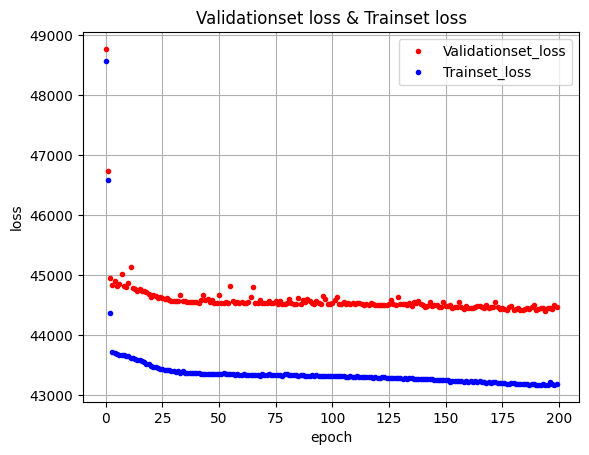

Evaluate on Test data
5502/5502 [==============================] - 10s 2ms/step - loss: 44466.0234 - mse: 44466.0234
Test Loss, Test Accuracy. [44466.0234375, 44466.0234375]


In [ ]:
seed = 777
X_tr, X_test, Y_tr, Y_test=train_test_split(X,Y,test_size=0.2, random_state=seed)
X_train, X_val, Y_train, Y_val=train_test_split(X_tr,Y_tr,test_size=0.25, random_state=seed)

model=Sequential()
model.add(Dense(7,input_dim=1,activation='relu'))
model.add(Dense(7,activation='relu'))
model.add(Dense(7,activation='relu'))
model.add(Dense(7,activation='relu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=100)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),
                  epochs=200,batch_size=128, callbacks=[early_stopping_callback])
model.save('ANN_NOT_PCA')
print(f'\n Validation Accuracy: {model.evaluate(X_val, Y_val)[1]}')

Y_vloss=history.history['val_loss']
Y_loss=history.history['loss']

X_len=np.arange(len(Y_loss))

plt.plot(X_len,Y_vloss,marker='o',linestyle = 'none', c='red',markersize=3,label='Validationset_loss')
plt.plot(X_len,Y_loss,marker='o',linestyle = 'none', c='blue',markersize=3,label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Validationset loss & Trainset loss")
plt.show()

print('Evaluate on Test data')
ANN_NOT_PCA=load_model('ANN_NOT_PCA')
EVAL_ANN = ANN_NOT_PCA.evaluate(X_test, Y_test, batch_size = 8)
print('Test Loss, Test Accuracy.', EVAL_ANN)

In [ ]:
file_sample = pd.read_csv('/content/sample_submission.csv')
df_sample = pd.DataFrame(file_sample)

test_input = df_test['DIST']
result = ANN_NOT_PCA.predict(test_input)
result_list = list()

7656/7656 [==============================] - 19s 3ms/step


In [ ]:
for i in range(len(result)):
  if list(df_test['DIST'])[i] == 0:
    result_list.append(0)
  else:
    result_list.append(result[i])

In [ ]:
result_list_after = list()
for i in result_list:
  result_list_after.append(float(i))

df_sample['CI_HOUR'] = result_list_after
df_sample.to_csv('submission_2.csv', index = False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

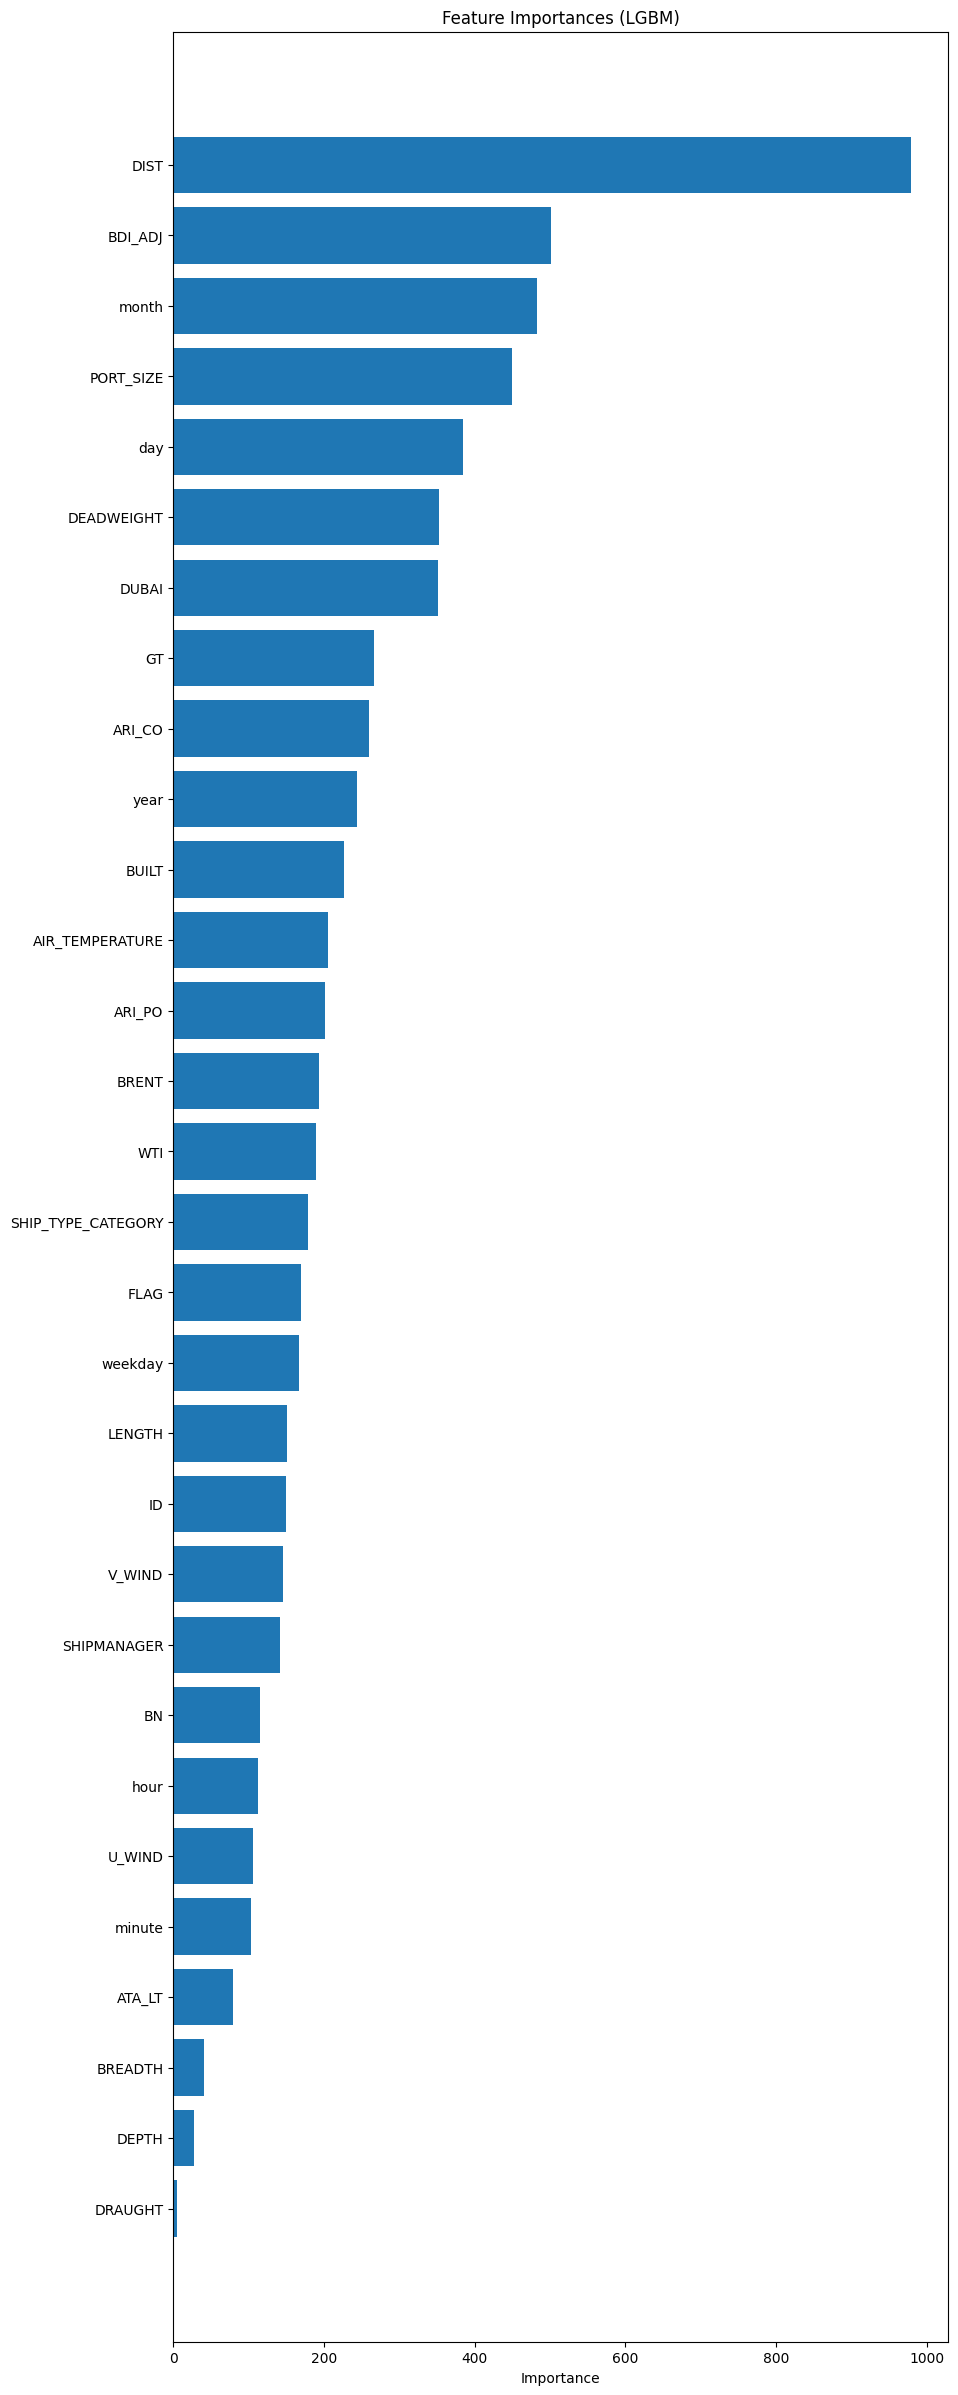

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3895
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 26
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:06<00:27,  6.95s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3898
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 26
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:13<00:21,  7.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3897
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 26
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:20<00:13,  6.89s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3893
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 26
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:27<00:06,  6.93s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3894
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 26
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:33<00:00,  6.79s/it]


Validation : MAE scores for each fold: [52.44761436967792, 53.98545924595779, 53.899907291538824, 52.94086651090125, 52.96564331748219]
Validation : MAE: 53.2478981471116


In [ ]:
# 피쳐 중요도 기반 Feature Selection & LGBM K-Fold 앙상블, Submission_3
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('submission_3.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


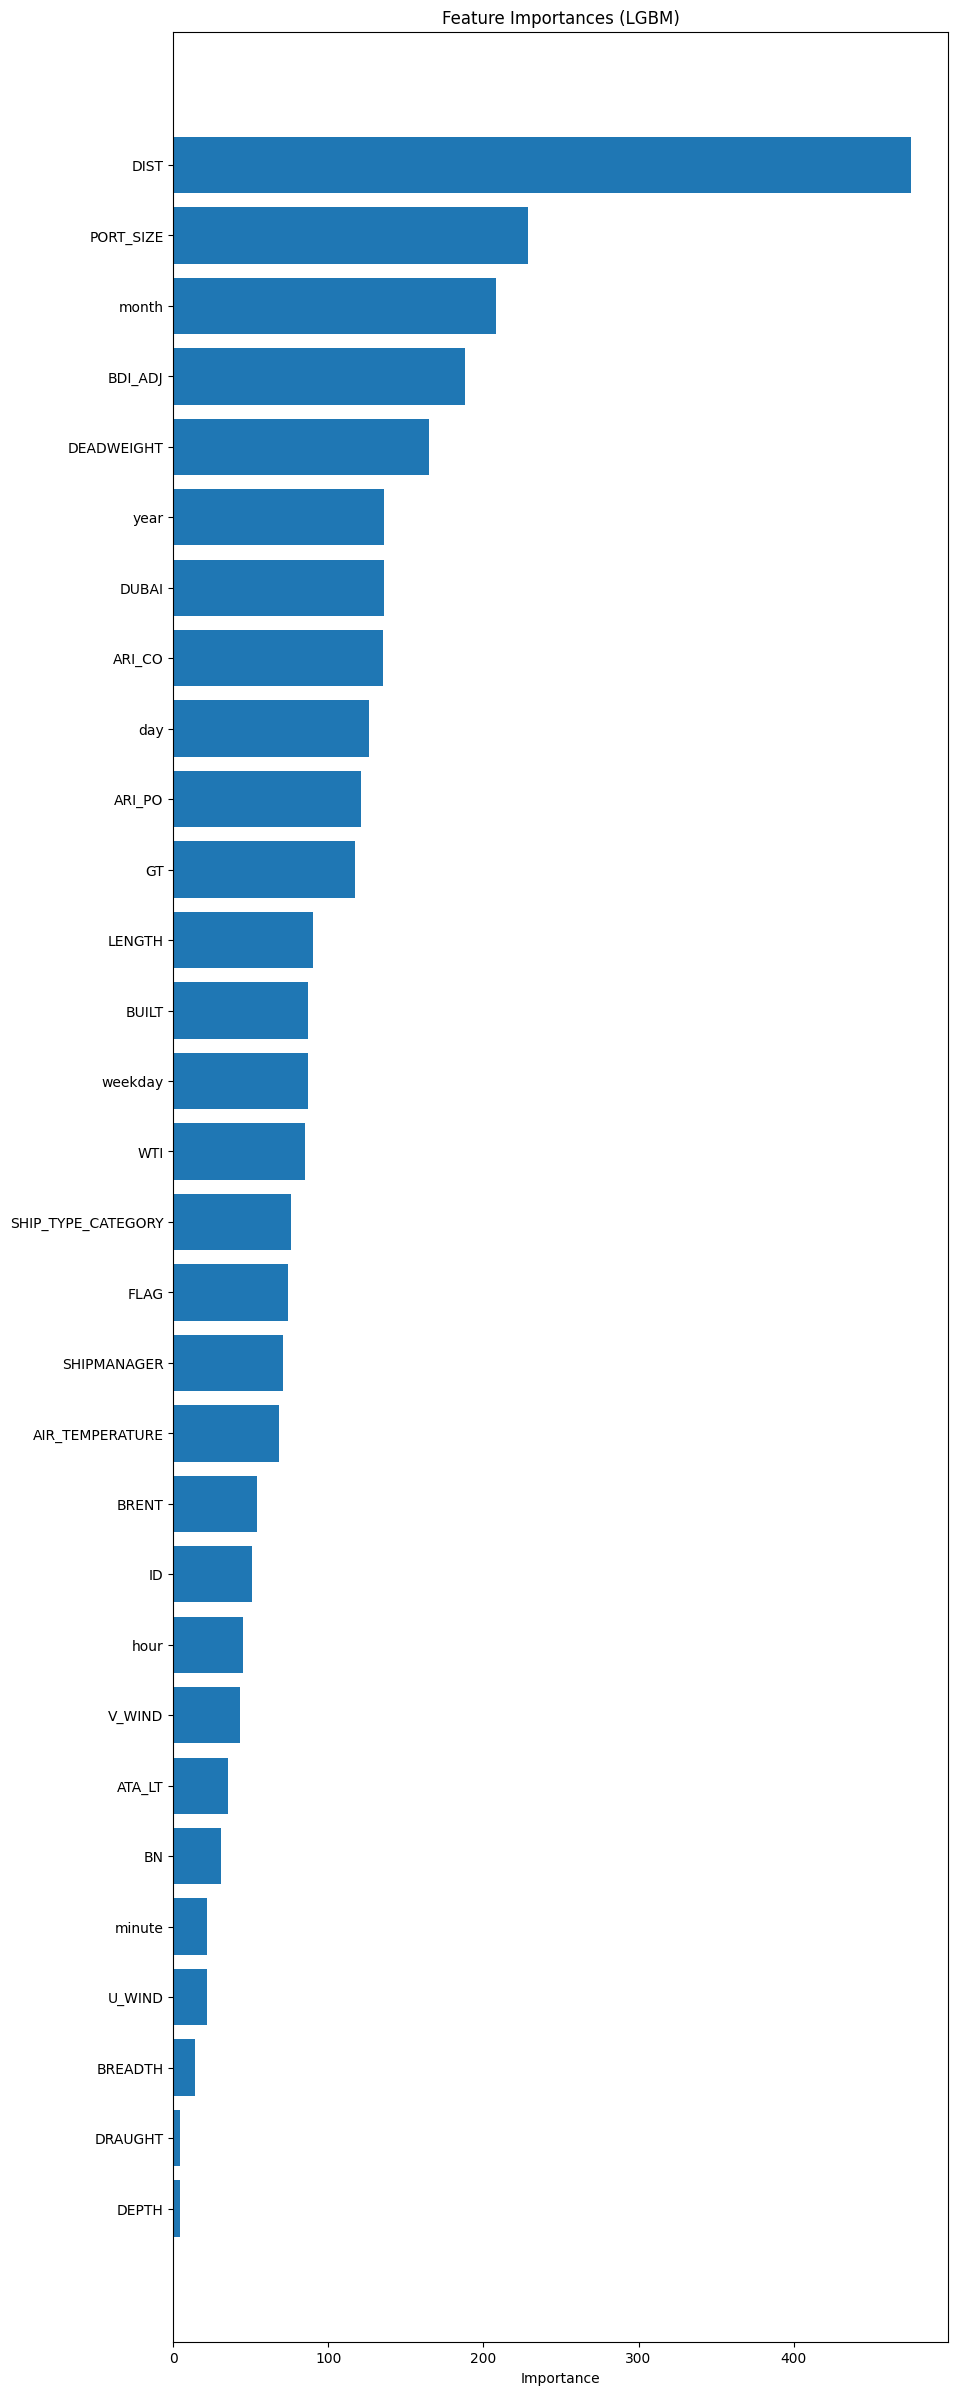

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 11
[LightGBM] [Info] Start training from score 62.047288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  20%|██        | 1/5 [00:06<00:24,  6.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.719969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  40%|████      | 2/5 [00:12<00:18,  6.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.754815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  60%|██████    | 3/5 [00:18<00:12,  6.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.868218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  80%|████████  | 4/5 [00:24<00:06,  6.24s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds: 100%|██████████| 5/5 [00:31<00:00,  6.22s/it]


Validation : MAE scores for each fold: [50.17732686948428, 50.7266646794421, 50.86376341661986, 51.16089748926132, 50.56943173391803]
Validation : MAE: 50.699616837745126


In [ ]:
# Submission_4
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 100 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 7, num_leaves = 75)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('submission_4.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


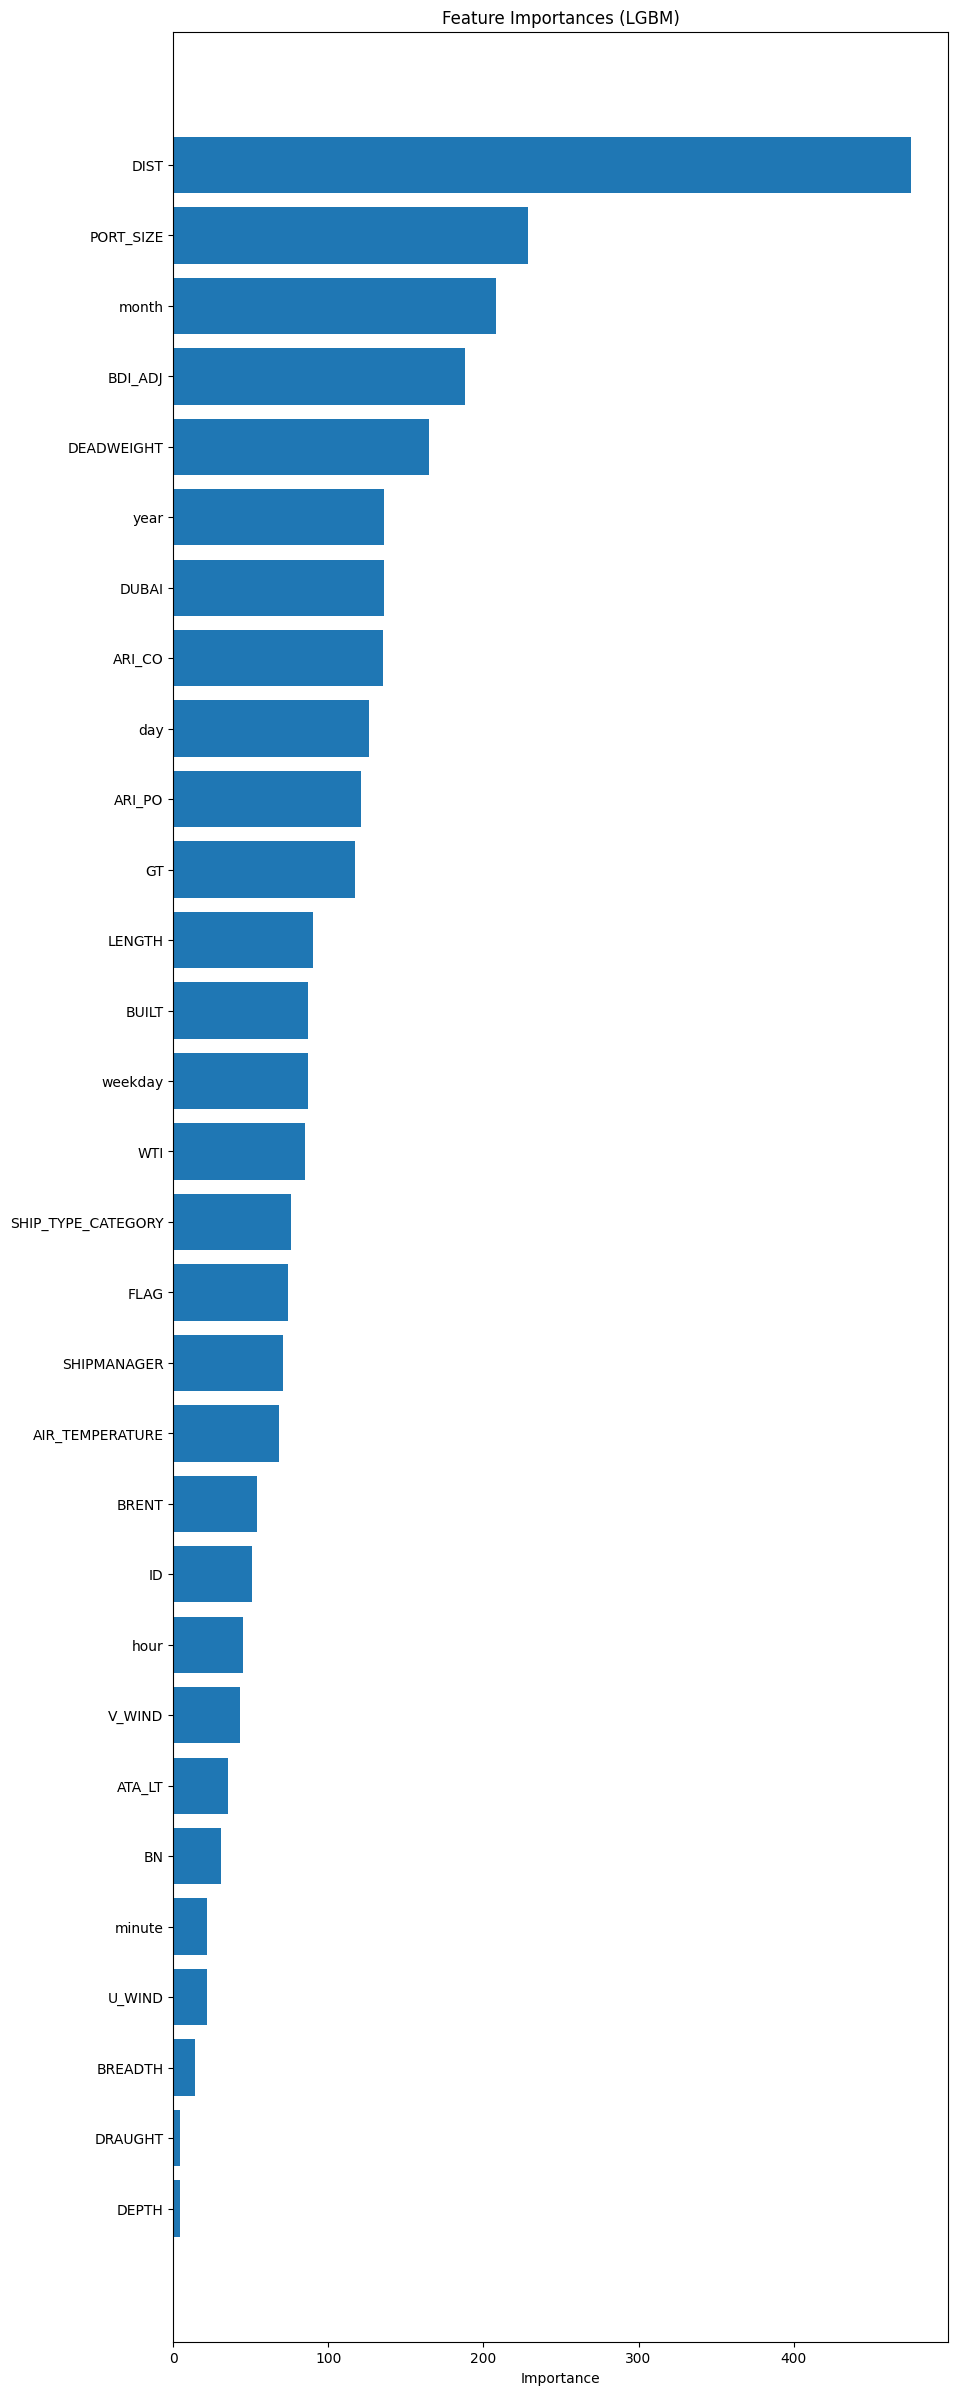

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  20%|██        | 1/5 [00:07<00:29,  7.32s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  40%|████      | 2/5 [00:15<00:23,  7.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  60%|██████    | 3/5 [00:23<00:15,  7.76s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  80%|████████  | 4/5 [00:30<00:07,  7.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds: 100%|██████████| 5/5 [00:38<00:00,  7.76s/it]


Validation : MAE scores for each fold: [47.61367088142332, 48.87872276570397, 48.65877291038644, 49.03535022188954, 48.116153010317014]
Validation : MAE: 48.46053395794406


In [ ]:
# Submission_5
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 80 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 8, num_leaves = 100)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('submission_5.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


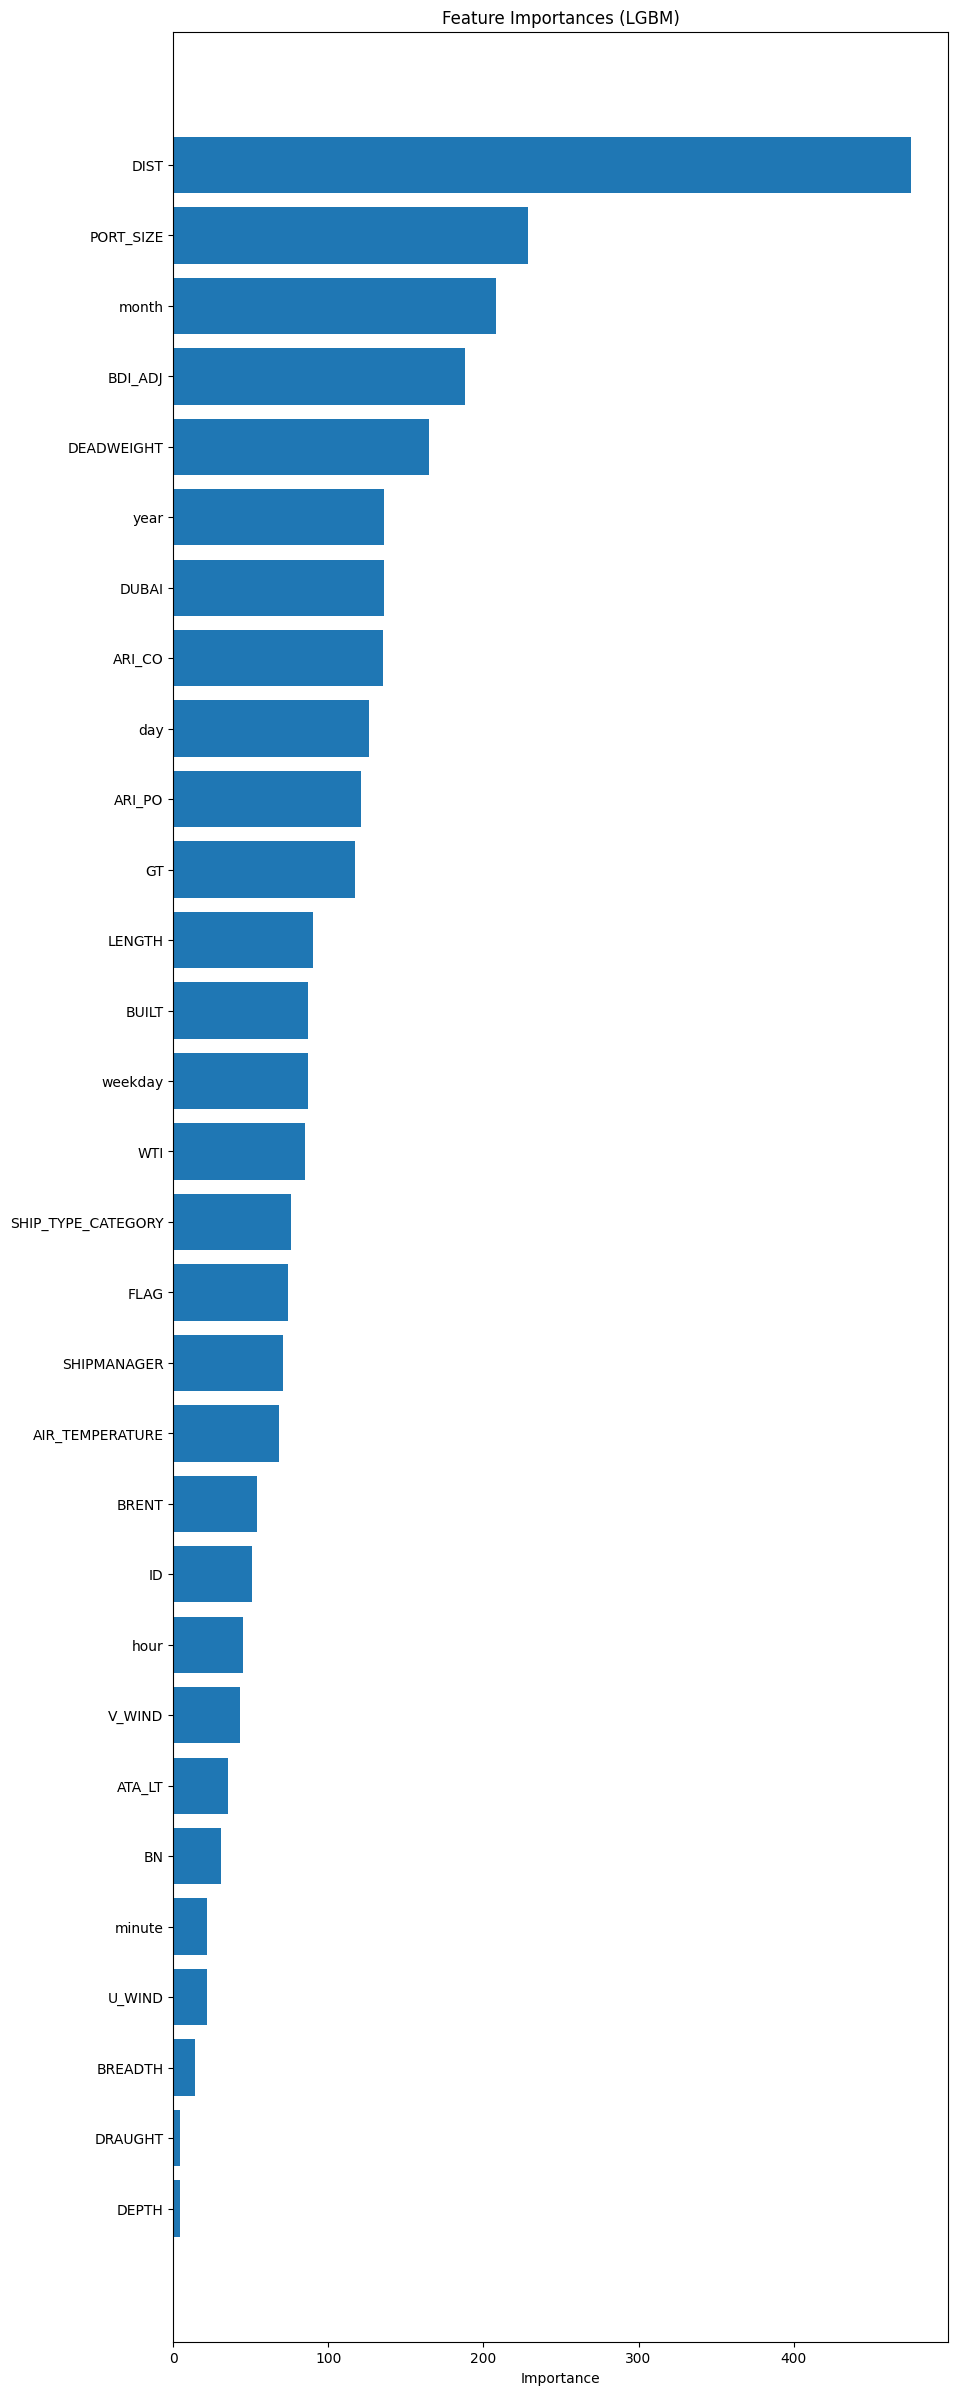

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:11<00:46, 11.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:23<00:35, 11.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:35<00:23, 11.79s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:46<00:11, 11.69s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [00:59<00:00, 11.92s/it]


Validation : MAE scores for each fold: [35.80709487561842, 37.802100113138565, 38.01308782636578, 37.04605901587382, 36.0286705993085]
Validation : MAE: 36.93940248606101


In [ ]:
# Submission_6
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 80 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 20, num_leaves = 500)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('submission_6.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


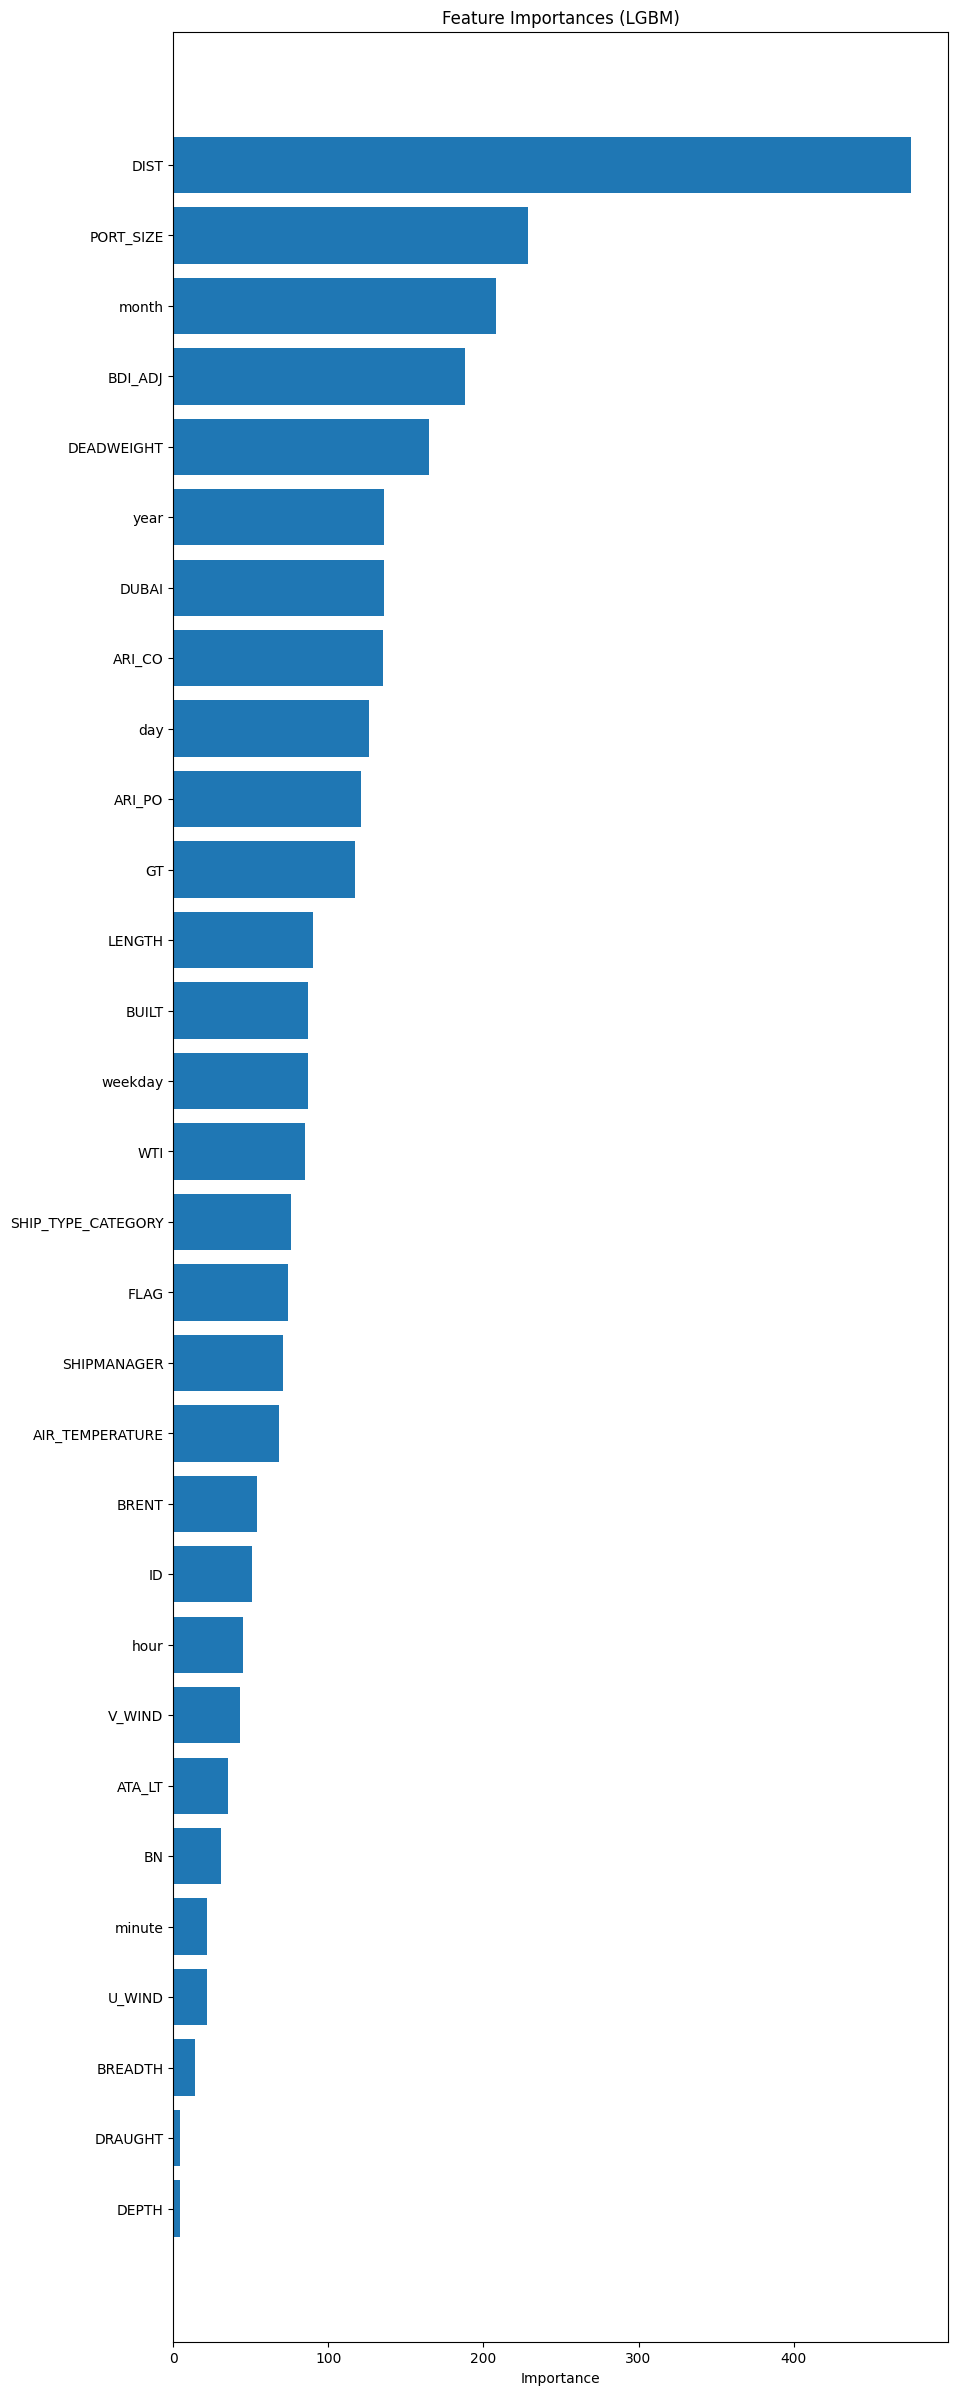

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 15
[LightGBM] [Info] Start training from score 62.047288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  20%|██        | 1/5 [00:28<01:54, 28.64s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.719969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  40%|████      | 2/5 [00:55<01:23, 27.87s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.754815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  60%|██████    | 3/5 [01:26<00:58, 29.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.868218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds:  80%|████████  | 4/5 [01:55<00:29, 29.05s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1919
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 15
[LightGBM] [Info] Start training from score 61.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

Processing folds: 100%|██████████| 5/5 [02:25<00:00, 29.00s/it]


Validation : MAE scores for each fold: [35.43565775120638, 36.497841680465754, 36.83681951949976, 36.80808318405222, 36.56728598156581]
Validation : MAE: 36.42913762335799


In [ ]:
# Submission_7
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 80 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 20, num_leaves = 2000)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('submission_7.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.90it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


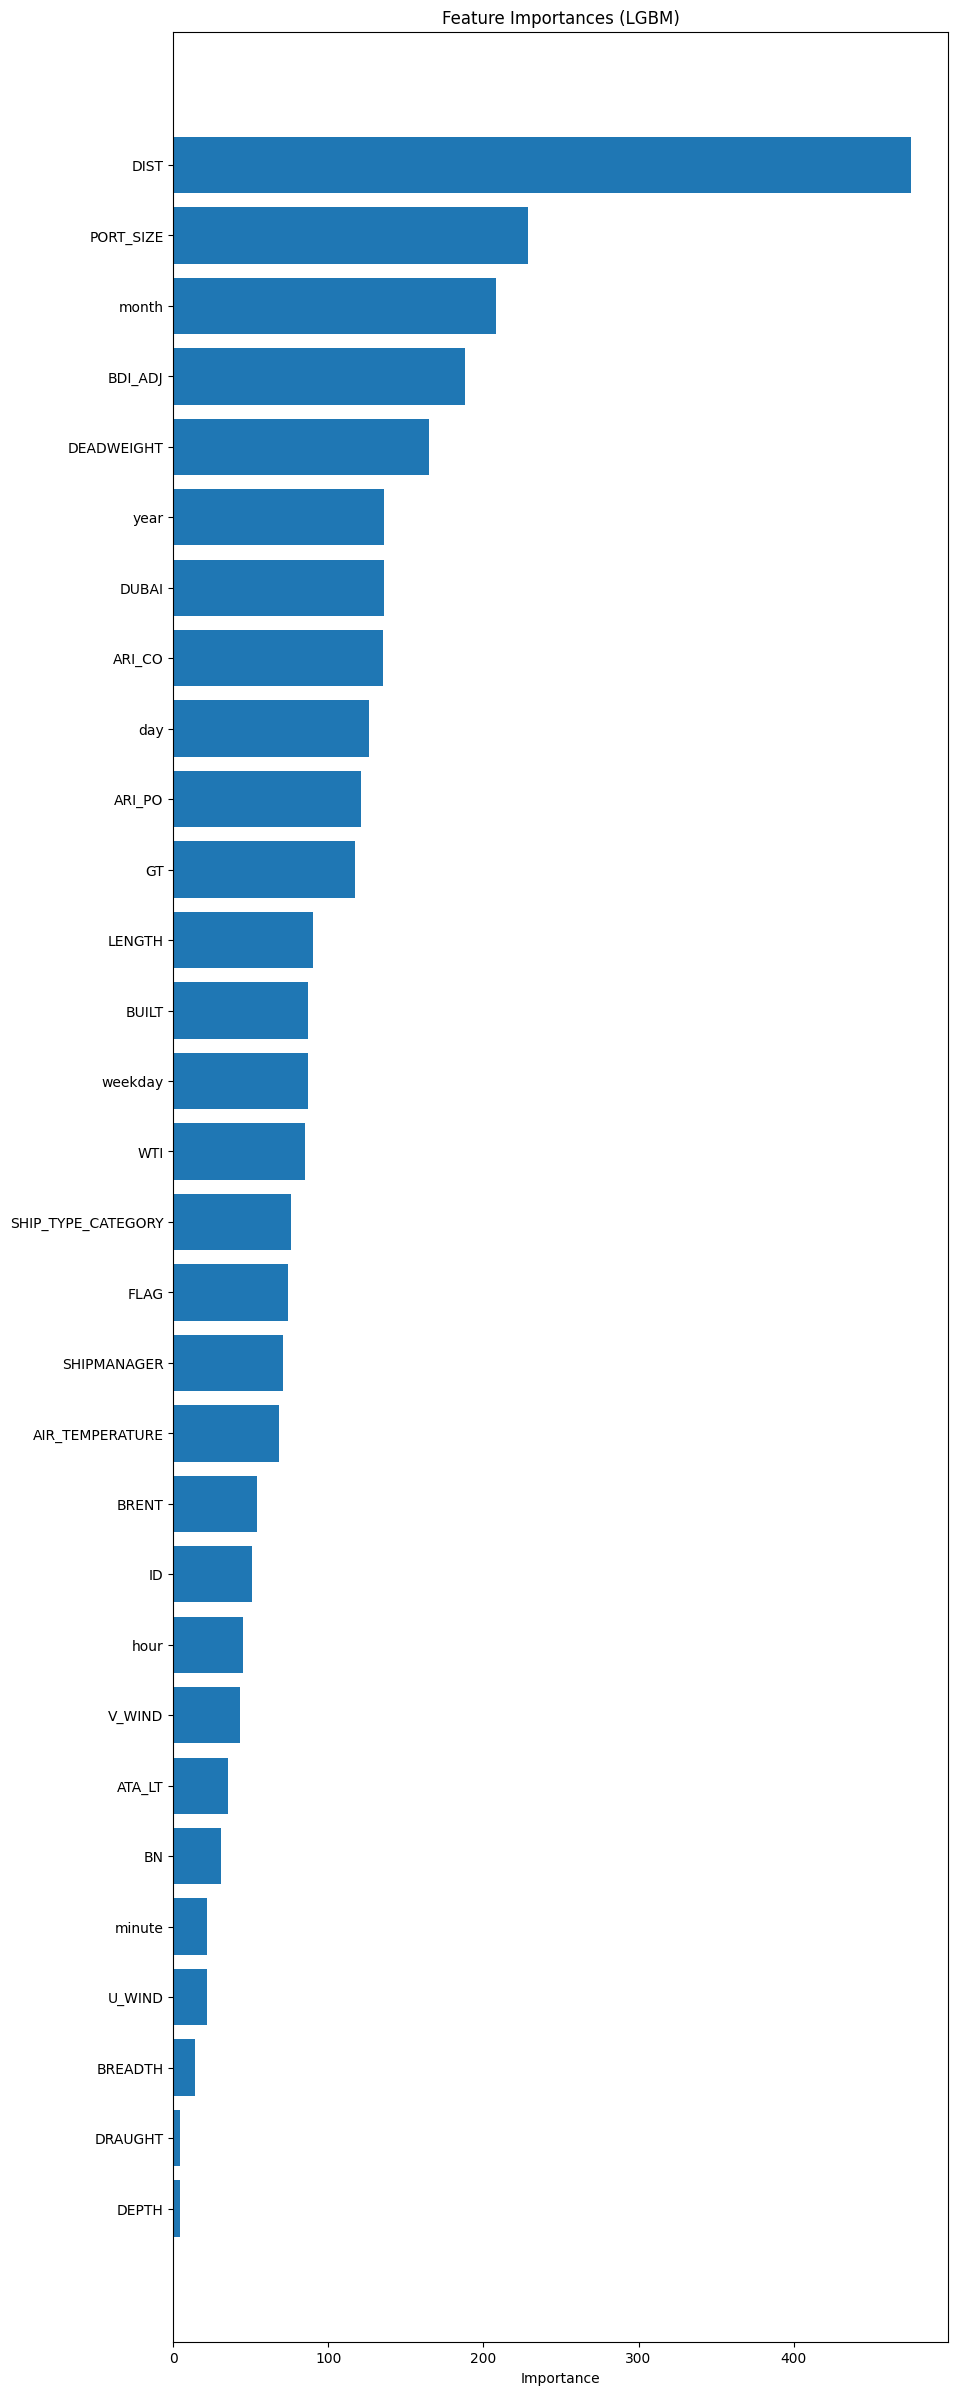

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 11
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:14<00:58, 14.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:29<00:44, 14.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:44<00:29, 14.86s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:58<00:14, 14.60s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1561
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 11
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [01:13<00:00, 14.71s/it]

Validation : MAE scores for each fold: [33.83266457621658, 34.697336237724095, 35.296806873030185, 35.07591303778357, 35.078035941494946]
Validation : MAE: 34.796151333249874


In [ ]:
# Submission_8
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 100 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
#submit.to_csv('submission_8.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


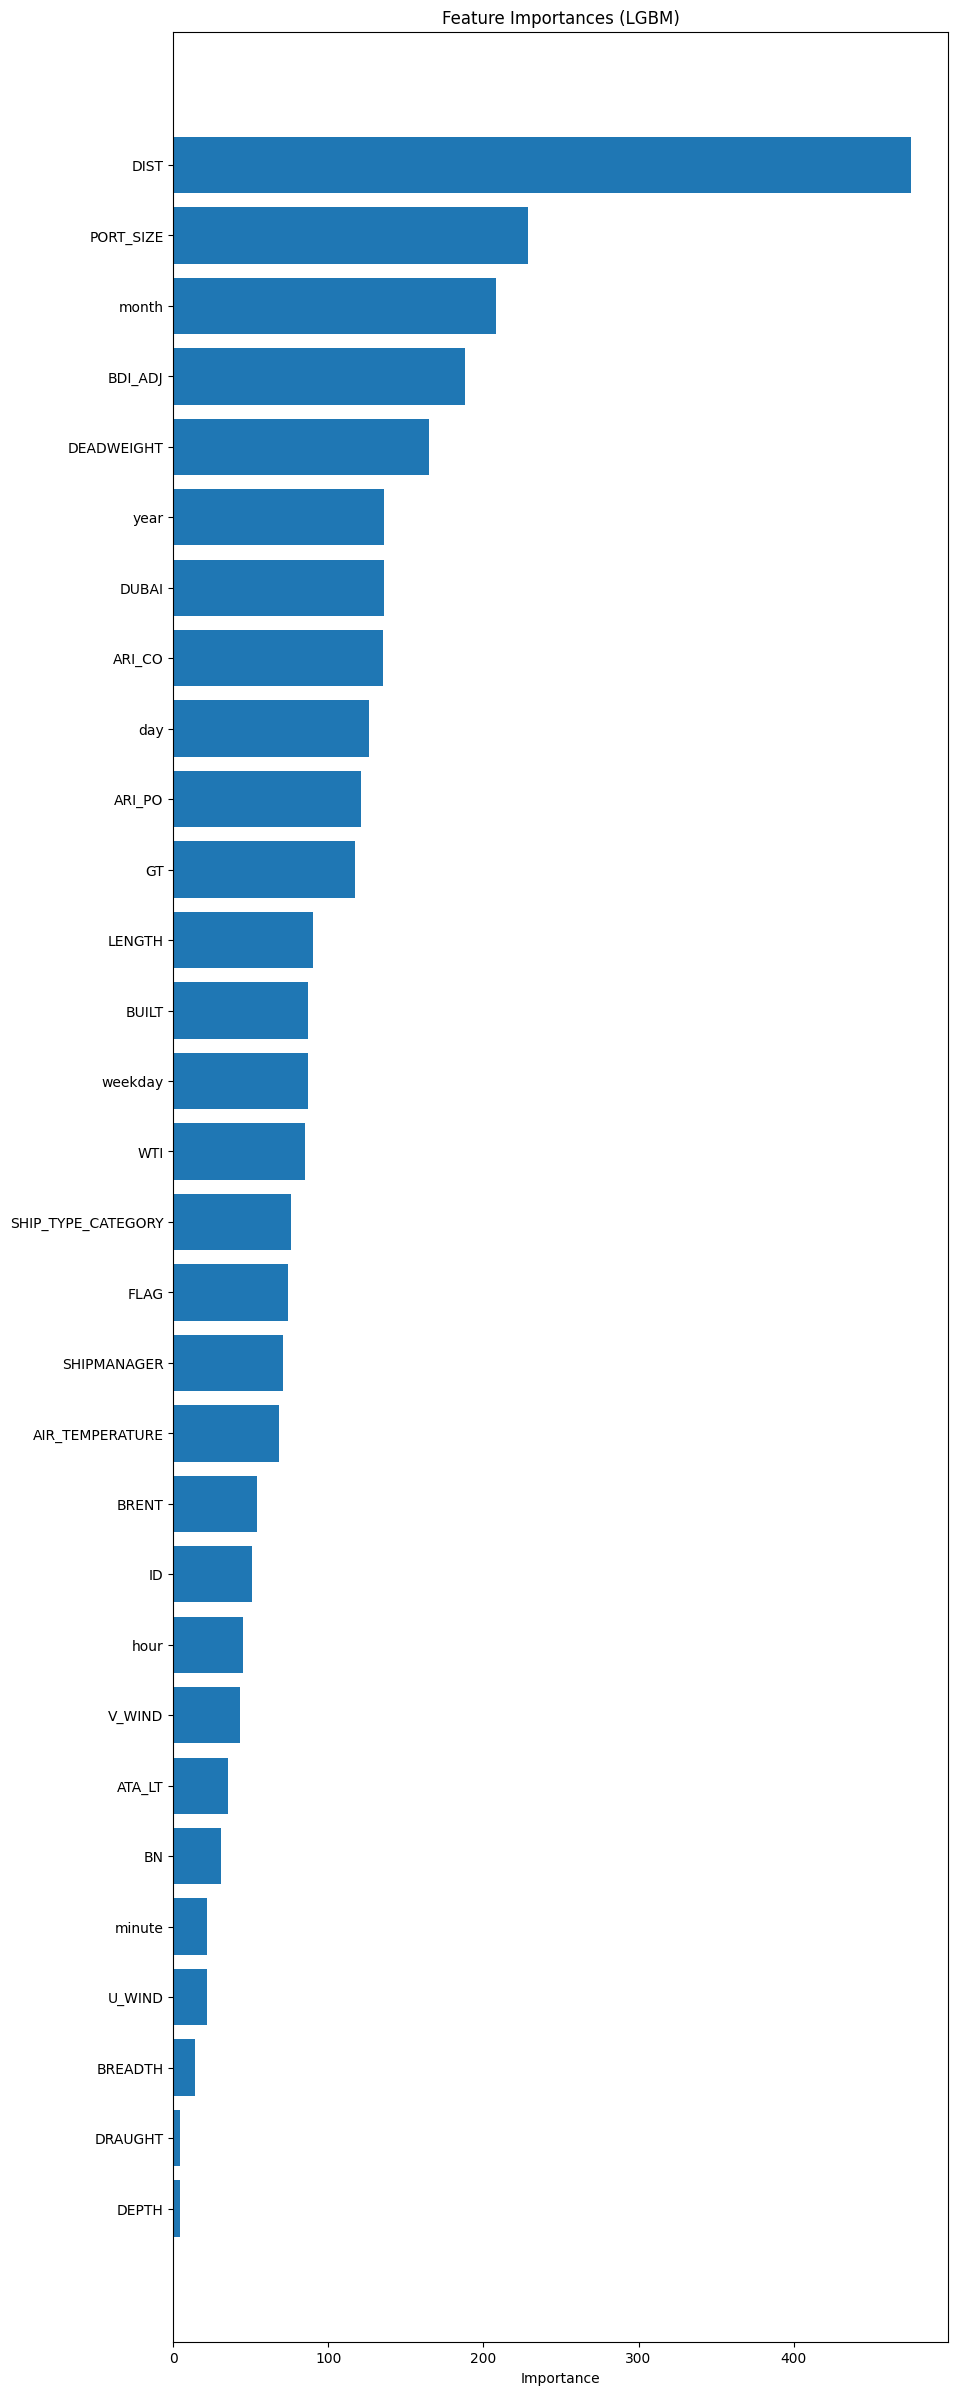

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 10
[LightGBM] [Info] Start training from score 62.047288


Processing folds:  20%|██        | 1/5 [00:14<00:56, 14.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 10
[LightGBM] [Info] Start training from score 61.719969


Processing folds:  40%|████      | 2/5 [00:27<00:41, 13.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 10
[LightGBM] [Info] Start training from score 61.754815


Processing folds:  60%|██████    | 3/5 [00:41<00:28, 14.01s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 10
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  80%|████████  | 4/5 [00:55<00:13, 13.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 10
[LightGBM] [Info] Start training from score 61.995298


Processing folds: 100%|██████████| 5/5 [01:10<00:00, 14.08s/it]

Validation : MAE scores for each fold: [33.868216862379136, 35.11751318109761, 34.14192286076629, 34.3697277546141, 34.75197460597511]
Validation : MAE: 34.44987105296645


In [ ]:
# Submission_9
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
#submit.to_csv('submission_8.csv', index=False)

In [ ]:
# Submission_10
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000)

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
#submit.to_csv('submission_8.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


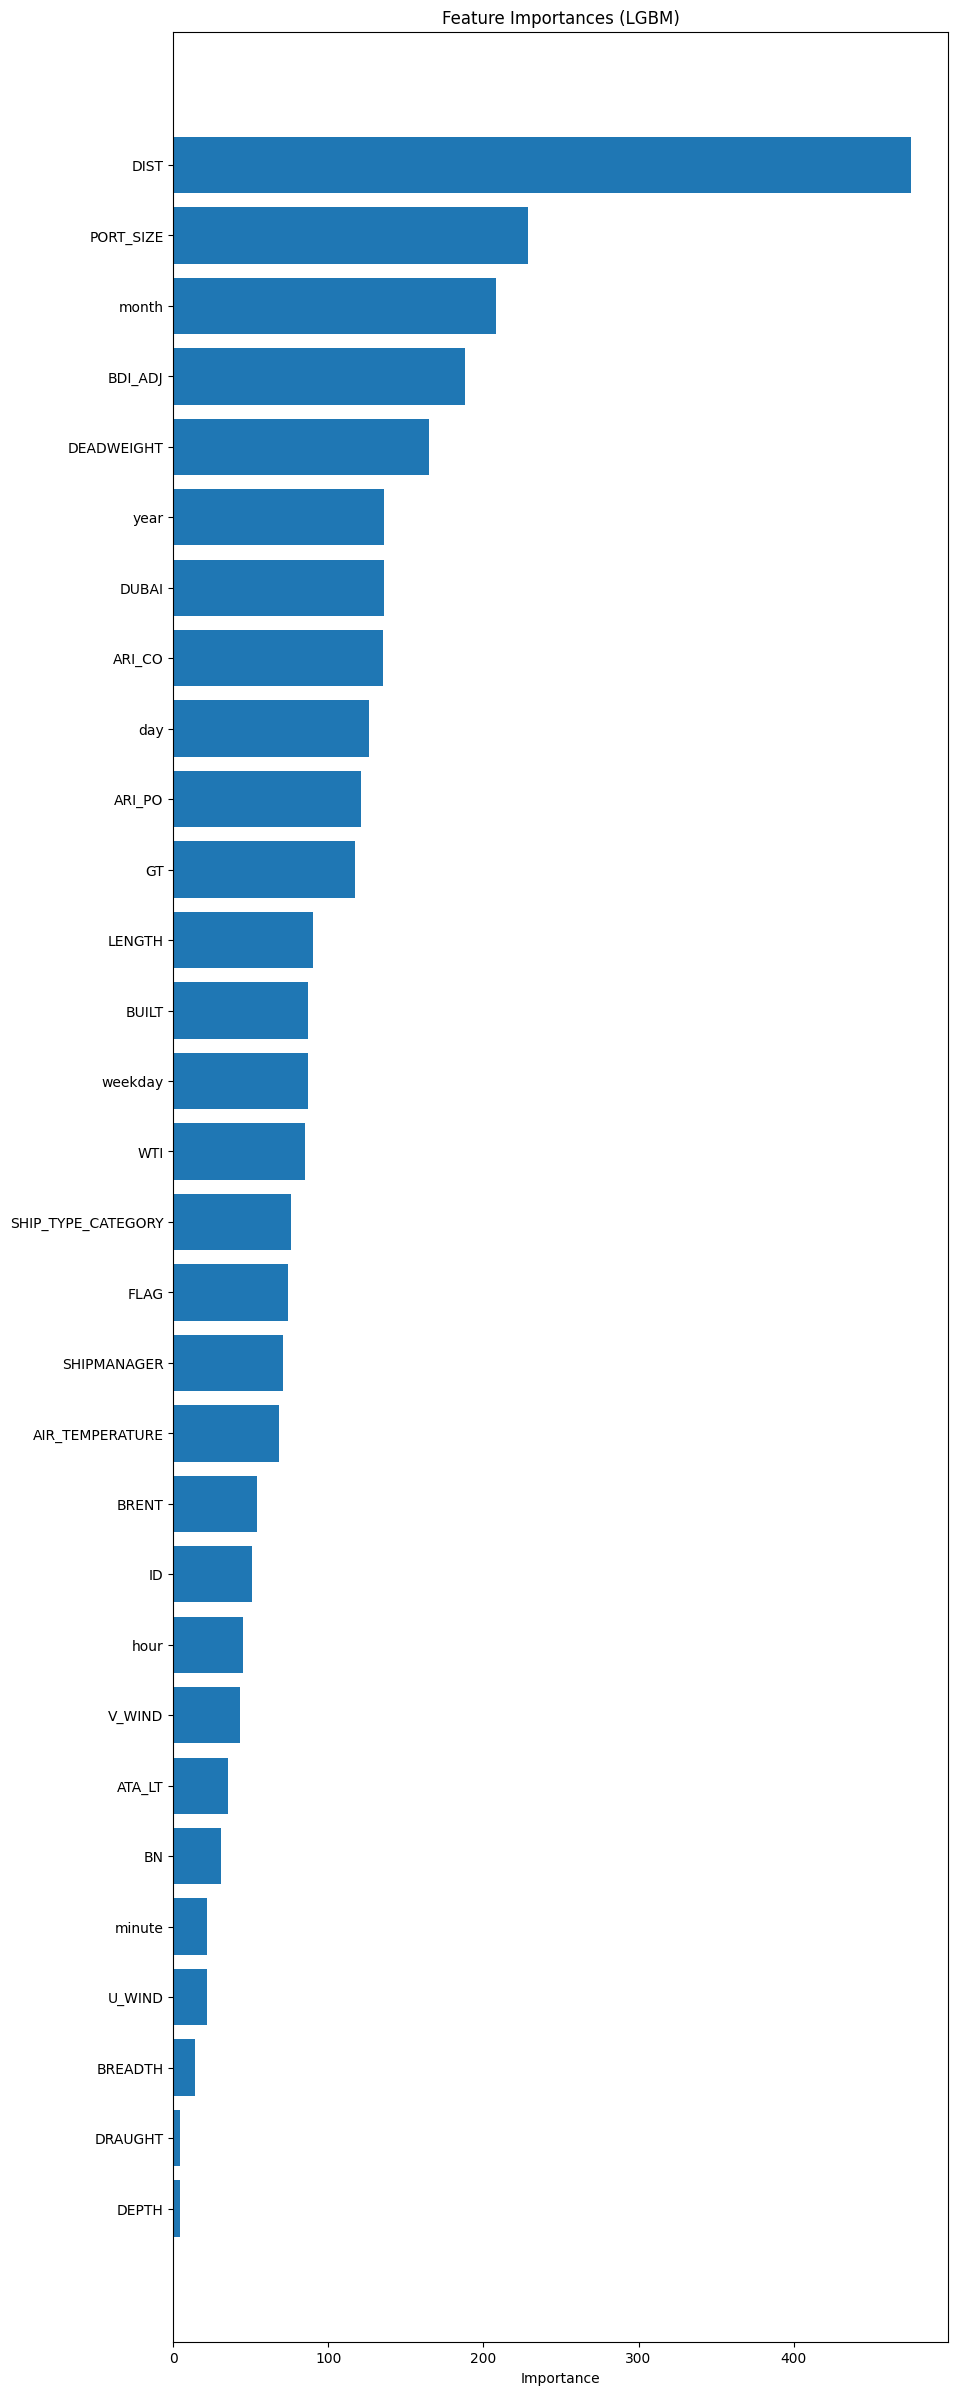

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330696, number of used features: 10
[LightGBM] [Info] Start training from score 61.950857
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  10%|█         | 1/10 [03:26<30:58, 206.50s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.954640
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  20%|██        | 2/10 [06:49<27:13, 204.17s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.874088
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  30%|███       | 3/10 [10:15<23:57, 205.35s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.740460
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  40%|████      | 4/10 [13:37<20:23, 203.93s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.738274
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  50%|█████     | 5/10 [17:07<17:10, 206.03s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.907248
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  60%|██████    | 6/10 [20:34<13:45, 206.37s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.985925
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  70%|███████   | 7/10 [24:05<10:23, 207.94s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.760399
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  80%|████████  | 8/10 [27:27<06:52, 206.04s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 62.042692
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  90%|█████████ | 9/10 [31:02<03:28, 209.00s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.816592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds: 100%|██████████| 10/10 [34:25<00:00, 206.57s/it]

Validation : MAE scores for each fold: [30.40480771103412, 29.621651086112745, 30.37161776669547, 30.646655329048716, 30.65657534579539, 30.15088691554604, 29.64725076680187, 30.717395711665635, 29.75816108638538, 30.309124575123047]
Validation : MAE: 30.22841262942084


In [ ]:
# Submission_11
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.02, feature_fraction = 0.7, bagging_fraction = 0.7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
#submit.to_csv('submission_8.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


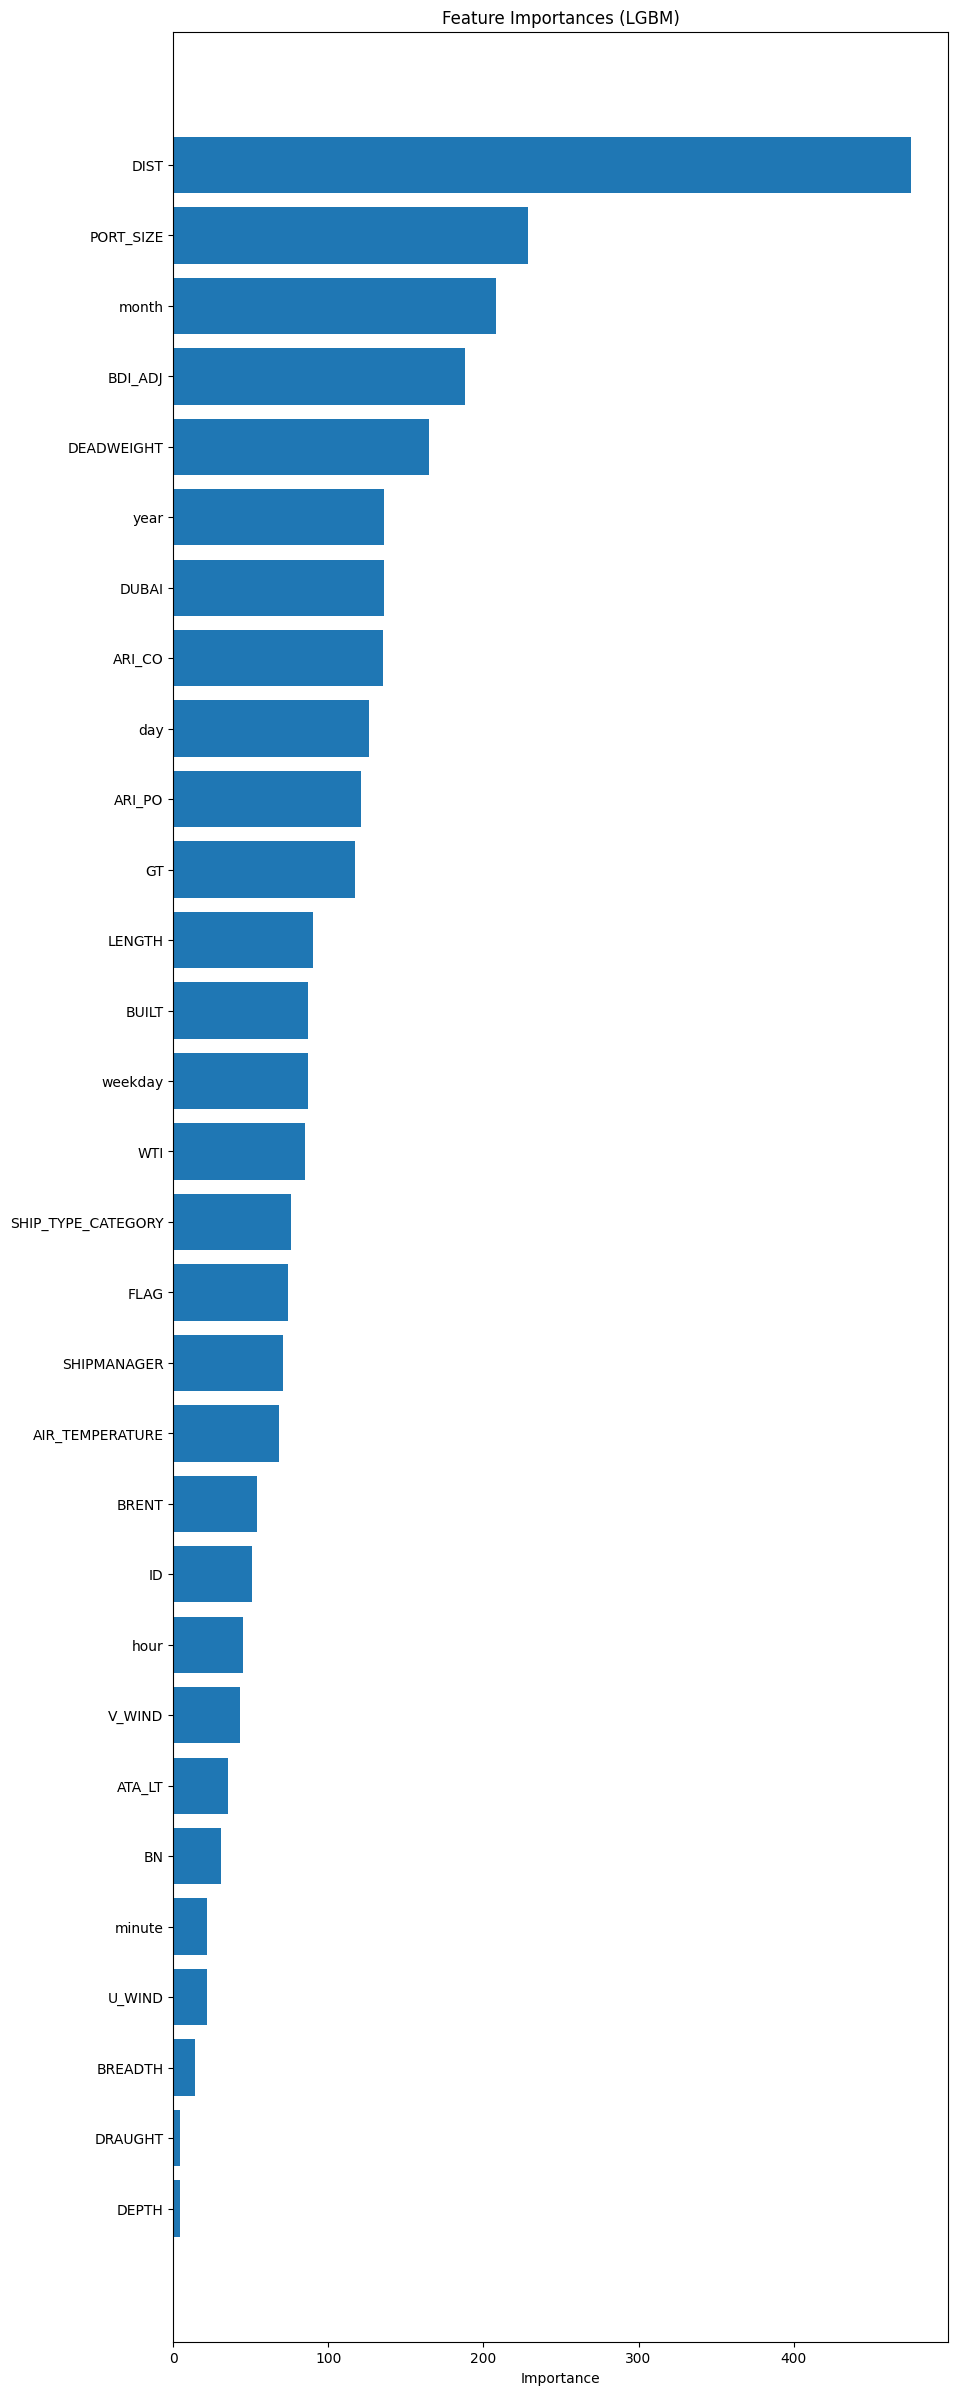

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330696, number of used features: 10
[LightGBM] [Info] Start training from score 61.950857
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  10%|█         | 1/10 [03:39<32:51, 219.02s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.954640
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  20%|██        | 2/10 [06:58<27:41, 207.70s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.874088
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  30%|███       | 3/10 [10:51<25:32, 218.96s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.740460
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  40%|████      | 4/10 [14:03<20:50, 208.43s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.738274
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  50%|█████     | 5/10 [17:17<16:55, 203.15s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.907248
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  60%|██████    | 6/10 [20:31<13:20, 200.05s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.985925
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  70%|███████   | 7/10 [23:51<10:00, 200.27s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.760399
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feat

Processing folds:  80%|████████  | 8/10 [27:08<06:38, 199.06s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 62.042692
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  90%|█████████ | 9/10 [30:24<03:18, 198.19s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.816592
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds: 100%|██████████| 10/10 [33:47<00:00, 202.70s/it]

Validation : MAE scores for each fold: [30.612283835539845, 29.988971199735843, 30.333993621521756, 30.807915273291478, 30.780034582519498, 30.07907167167854, 29.77317293196263, 30.905108101805826, 29.76183306274563, 30.800000316838567]
Validation : MAE: 30.384238459763957


In [ ]:
# Submission_12
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.02, feature_fraction = 0.9, bagging_fraction = 0.9)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
#submit.to_csv('submission_8.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


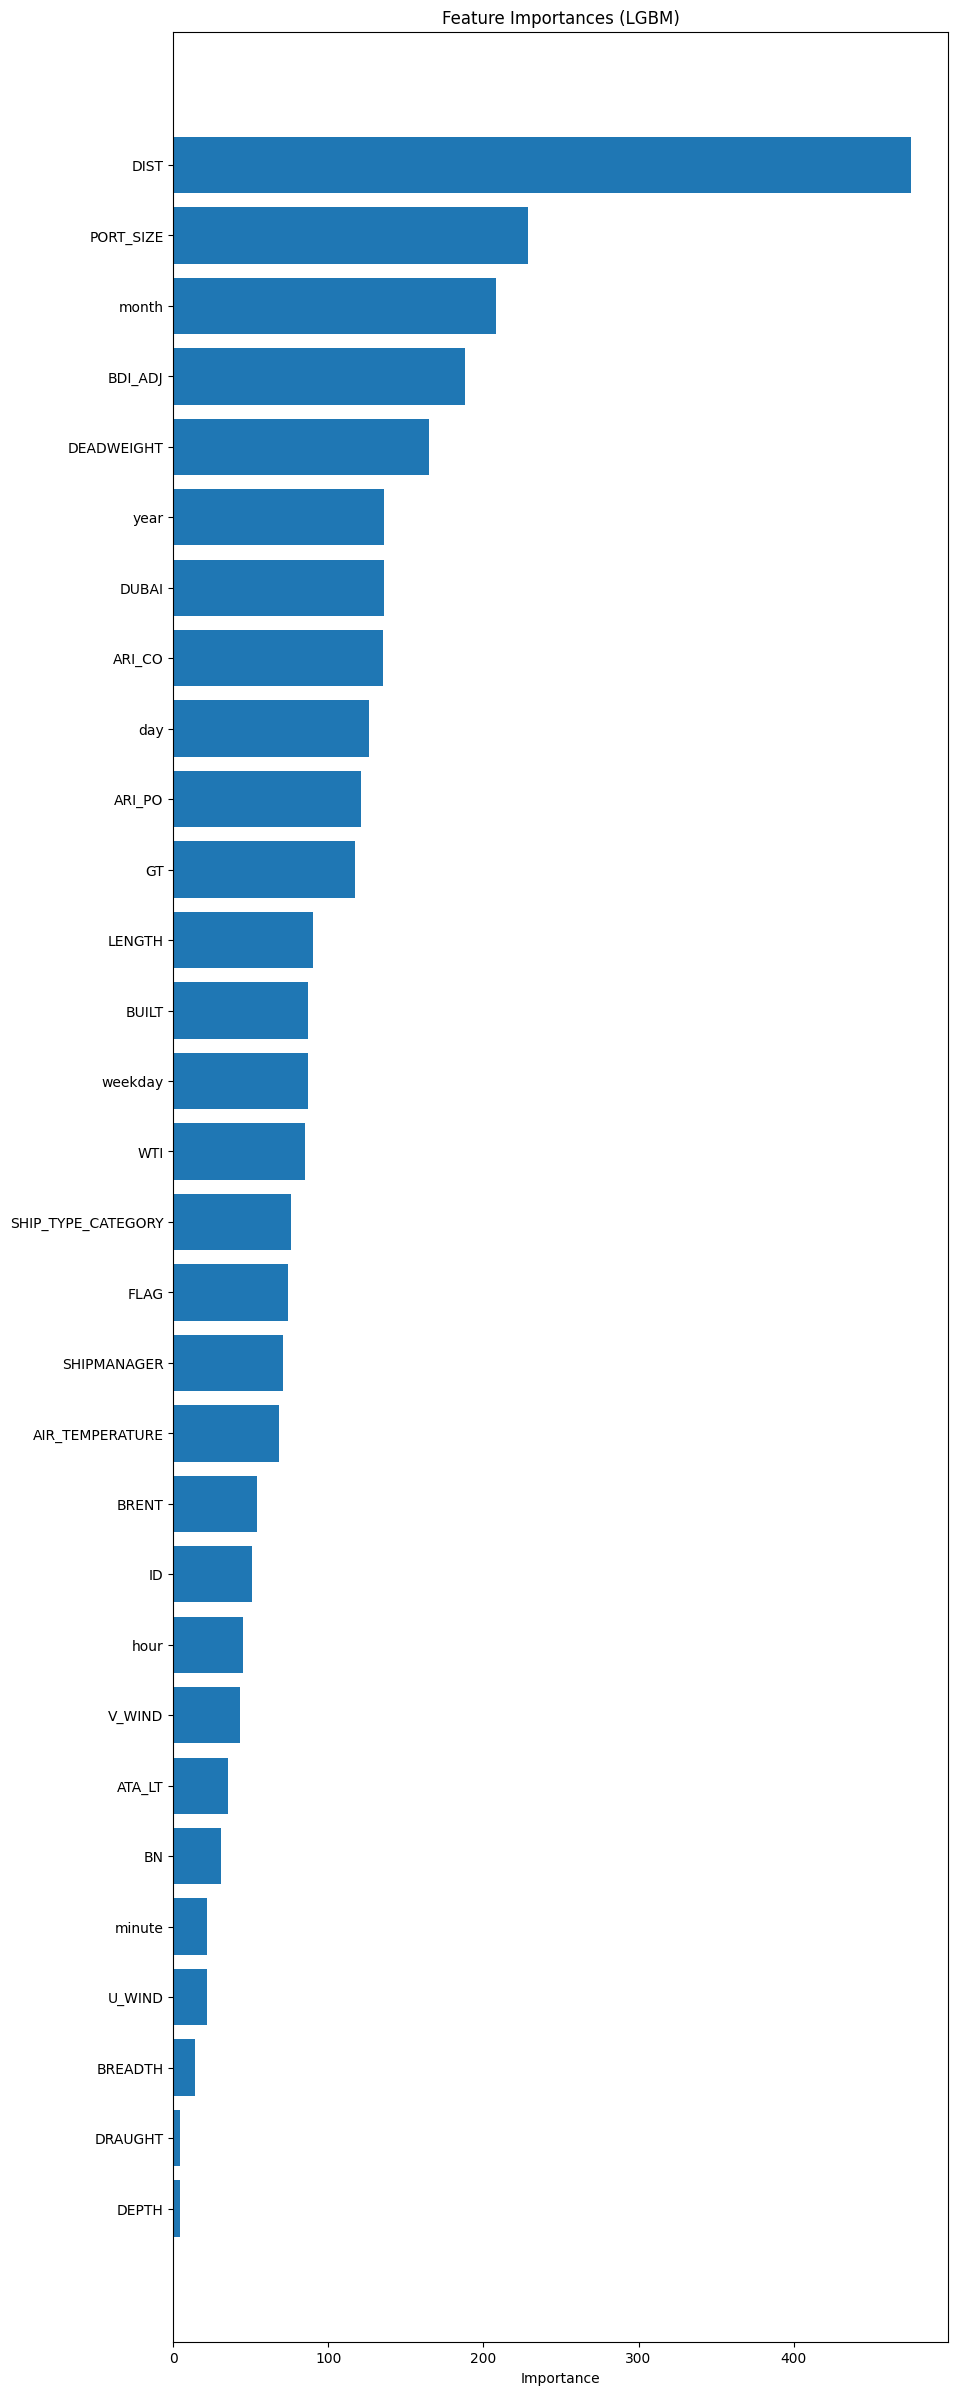

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330696, number of used features: 10
[LightGBM] [Info] Start training from score 61.950857
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  10%|█         | 1/10 [03:29<31:24, 209.36s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.954640
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  20%|██        | 2/10 [06:40<26:30, 198.86s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.874088
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  30%|███       | 3/10 [09:52<22:50, 195.72s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.740460
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  40%|████      | 4/10 [12:56<19:06, 191.00s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.738274
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  50%|█████     | 5/10 [16:03<15:47, 189.49s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.907248
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  60%|██████    | 6/10 [19:05<12:28, 187.03s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.985925
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  70%|███████   | 7/10 [22:12<09:20, 186.82s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1304
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.760399
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  80%|████████  | 8/10 [25:13<06:10, 185.05s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 62.042692
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  90%|█████████ | 9/10 [28:16<03:04, 184.34s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1306
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 10
[LightGBM] [Info] Start training from score 61.816592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds: 100%|██████████| 10/10 [31:15<00:00, 187.52s/it]

Validation : MAE scores for each fold: [27.67206457960385, 27.483722268591695, 27.926962021222174, 27.926148565834154, 28.18400659128745, 27.634131160072137, 27.35188731056616, 28.146186864887593, 27.24262771017821, 27.981372215036394]
Validation : MAE: 27.75491092872798


In [ ]:
# Submission_13
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.05, feature_fraction = 0.7, bagging_fraction = 0.7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
# submit.to_csv('submission_13.csv', index=False)

In [ ]:
submit.to_csv('submission_13.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


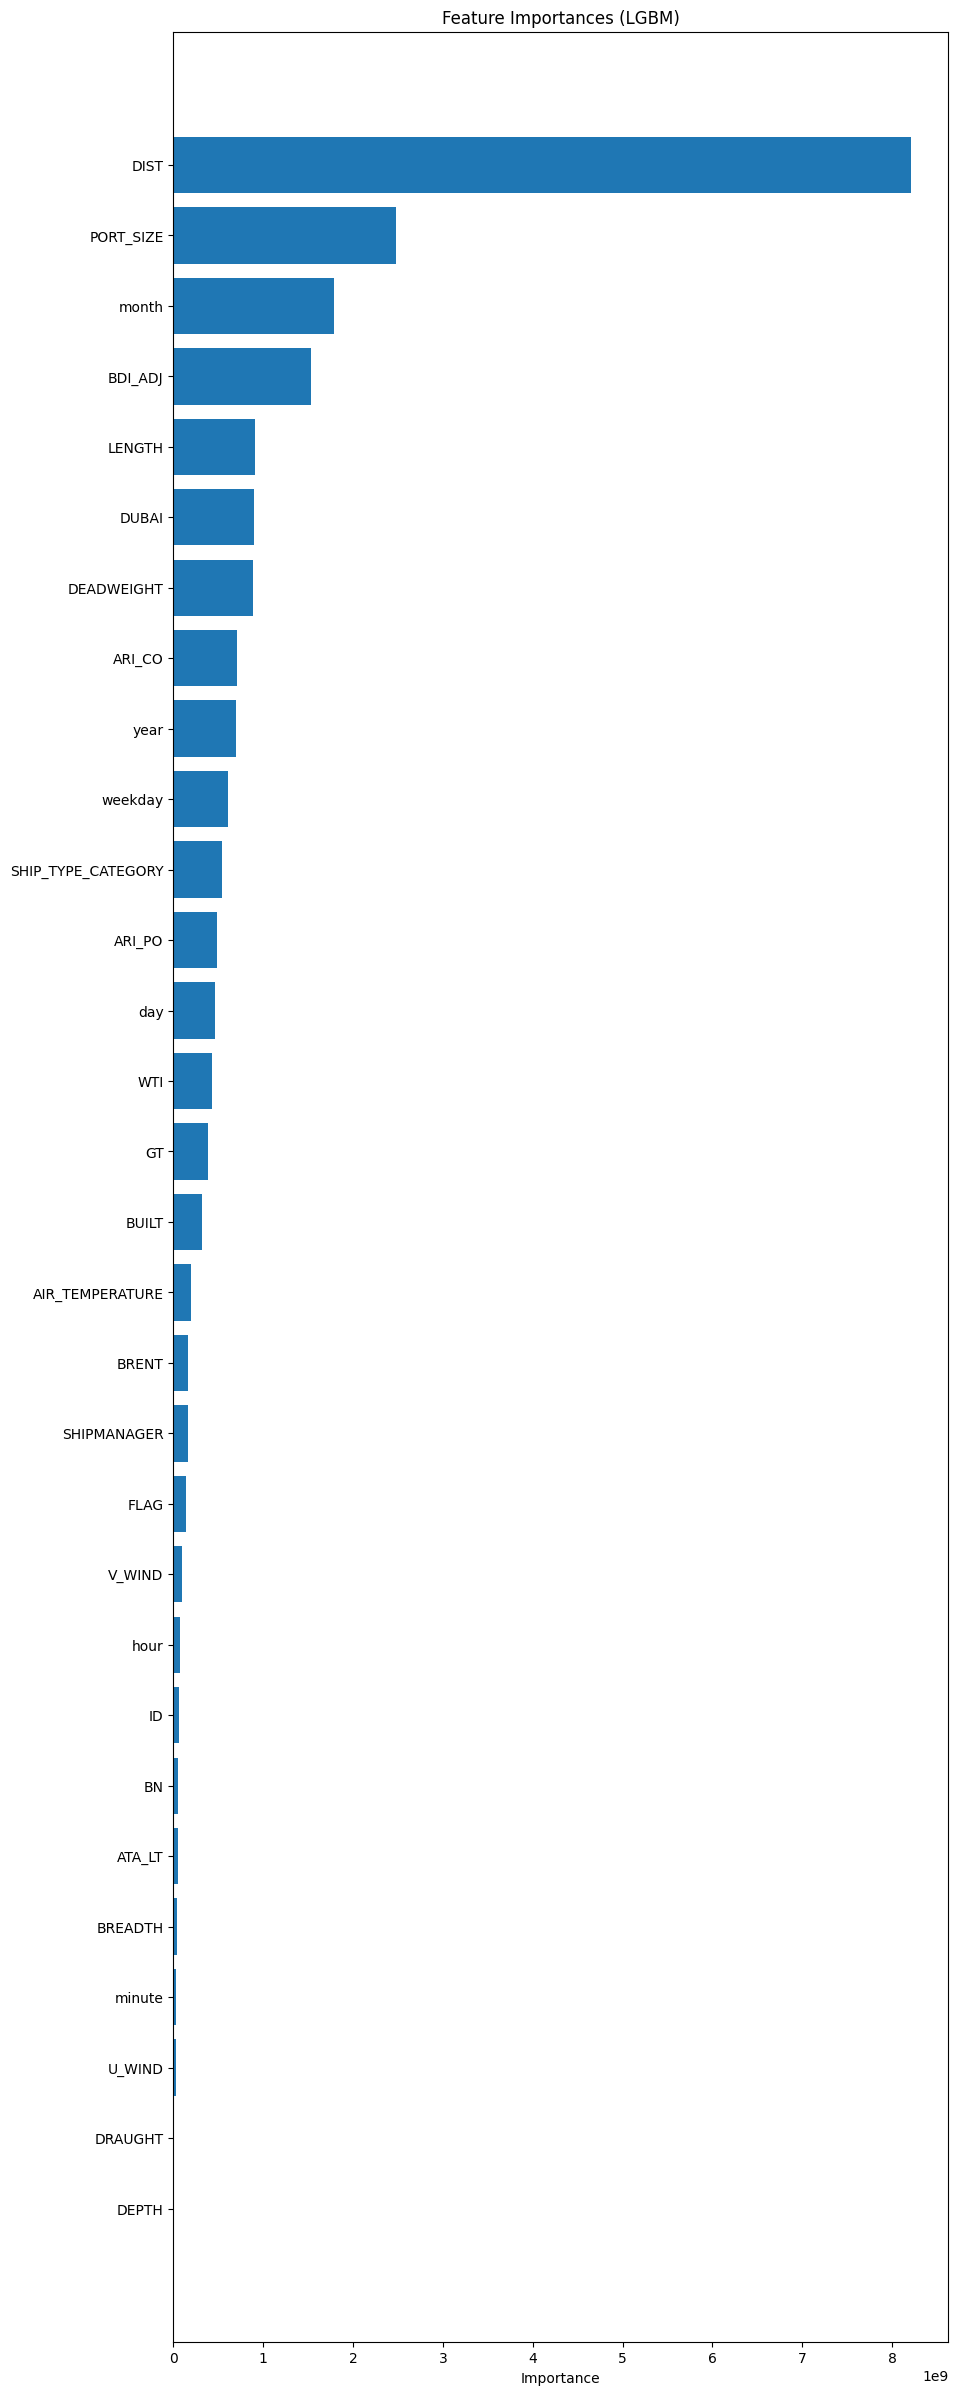

In [ ]:
# Lgbm_Feature_Selection_Gain (정규화 필요)
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, y_train)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


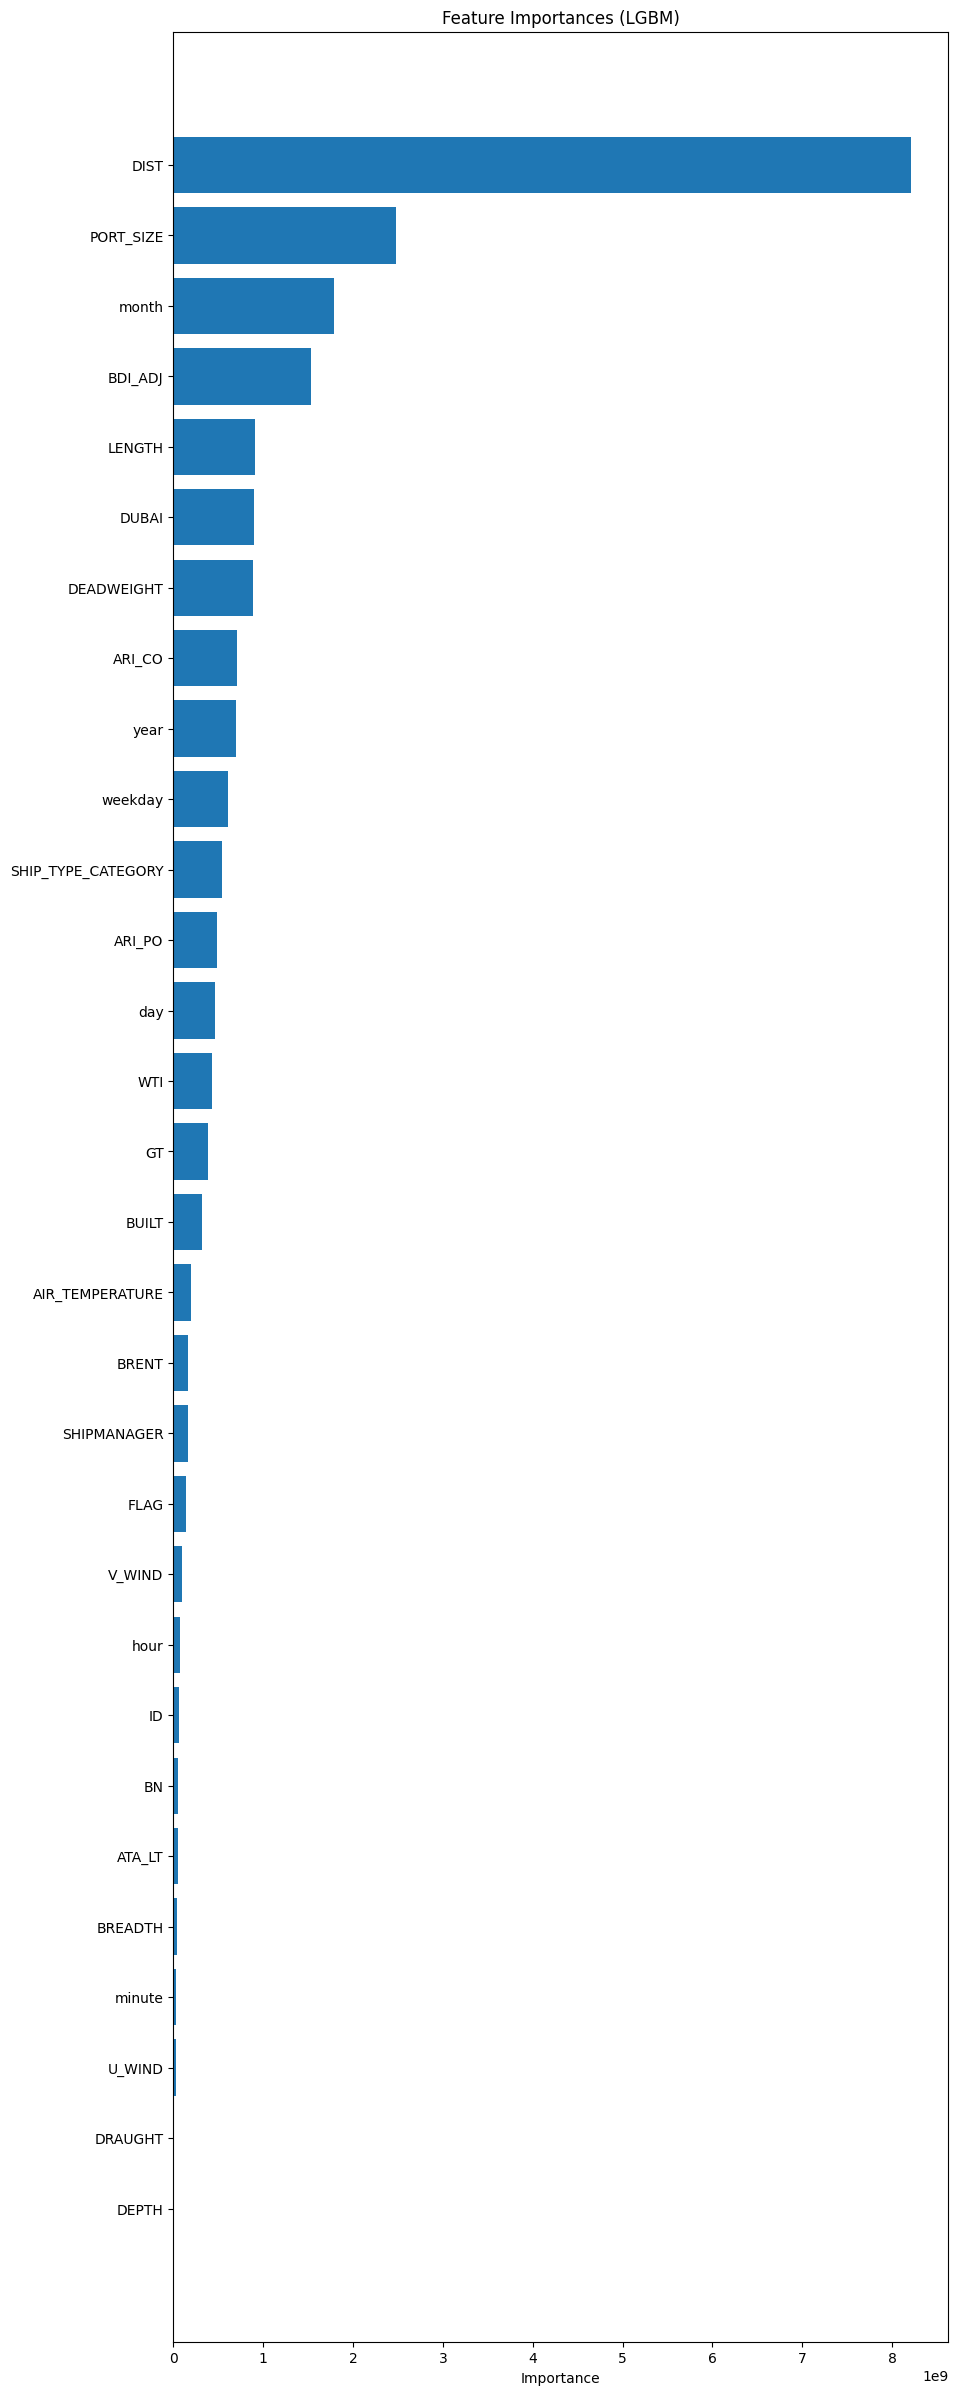

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330696, number of used features: 14
[LightGBM] [Info] Start training from score 61.950857
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  10%|█         | 1/10 [03:14<29:13, 194.82s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.954640
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  20%|██        | 2/10 [06:27<25:47, 193.41s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.874088
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  30%|███       | 3/10 [09:44<22:46, 195.24s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.740460
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  40%|████      | 4/10 [12:59<19:31, 195.20s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.738274
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  50%|█████     | 5/10 [16:13<16:13, 194.78s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.907248
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  60%|██████    | 6/10 [19:23<12:51, 192.97s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.985925
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  70%|███████   | 7/10 [22:43<09:46, 195.48s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1608
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.760399
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  80%|████████  | 8/10 [25:56<06:28, 194.41s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 62.042692
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  90%|█████████ | 9/10 [29:17<03:16, 196.65s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1610
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 14
[LightGBM] [Info] Start training from score 61.816592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds: 100%|██████████| 10/10 [32:30<00:00, 195.05s/it]

Validation : MAE scores for each fold: [27.910108066110624, 27.813183155611235, 28.244197972795497, 28.490808191999374, 28.895471227258884, 28.015798237892813, 27.732718346425777, 28.99817813148542, 27.817463525287167, 28.26090769399217]
Validation : MAE: 28.217883454885897


In [ ]:
# Submission_14 (#13 + gain)
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, y_train)

threshold = 0.4e9 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.05, feature_fraction = 0.7, bagging_fraction = 0.7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
# submit.to_csv('submission_13.csv', index=False)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


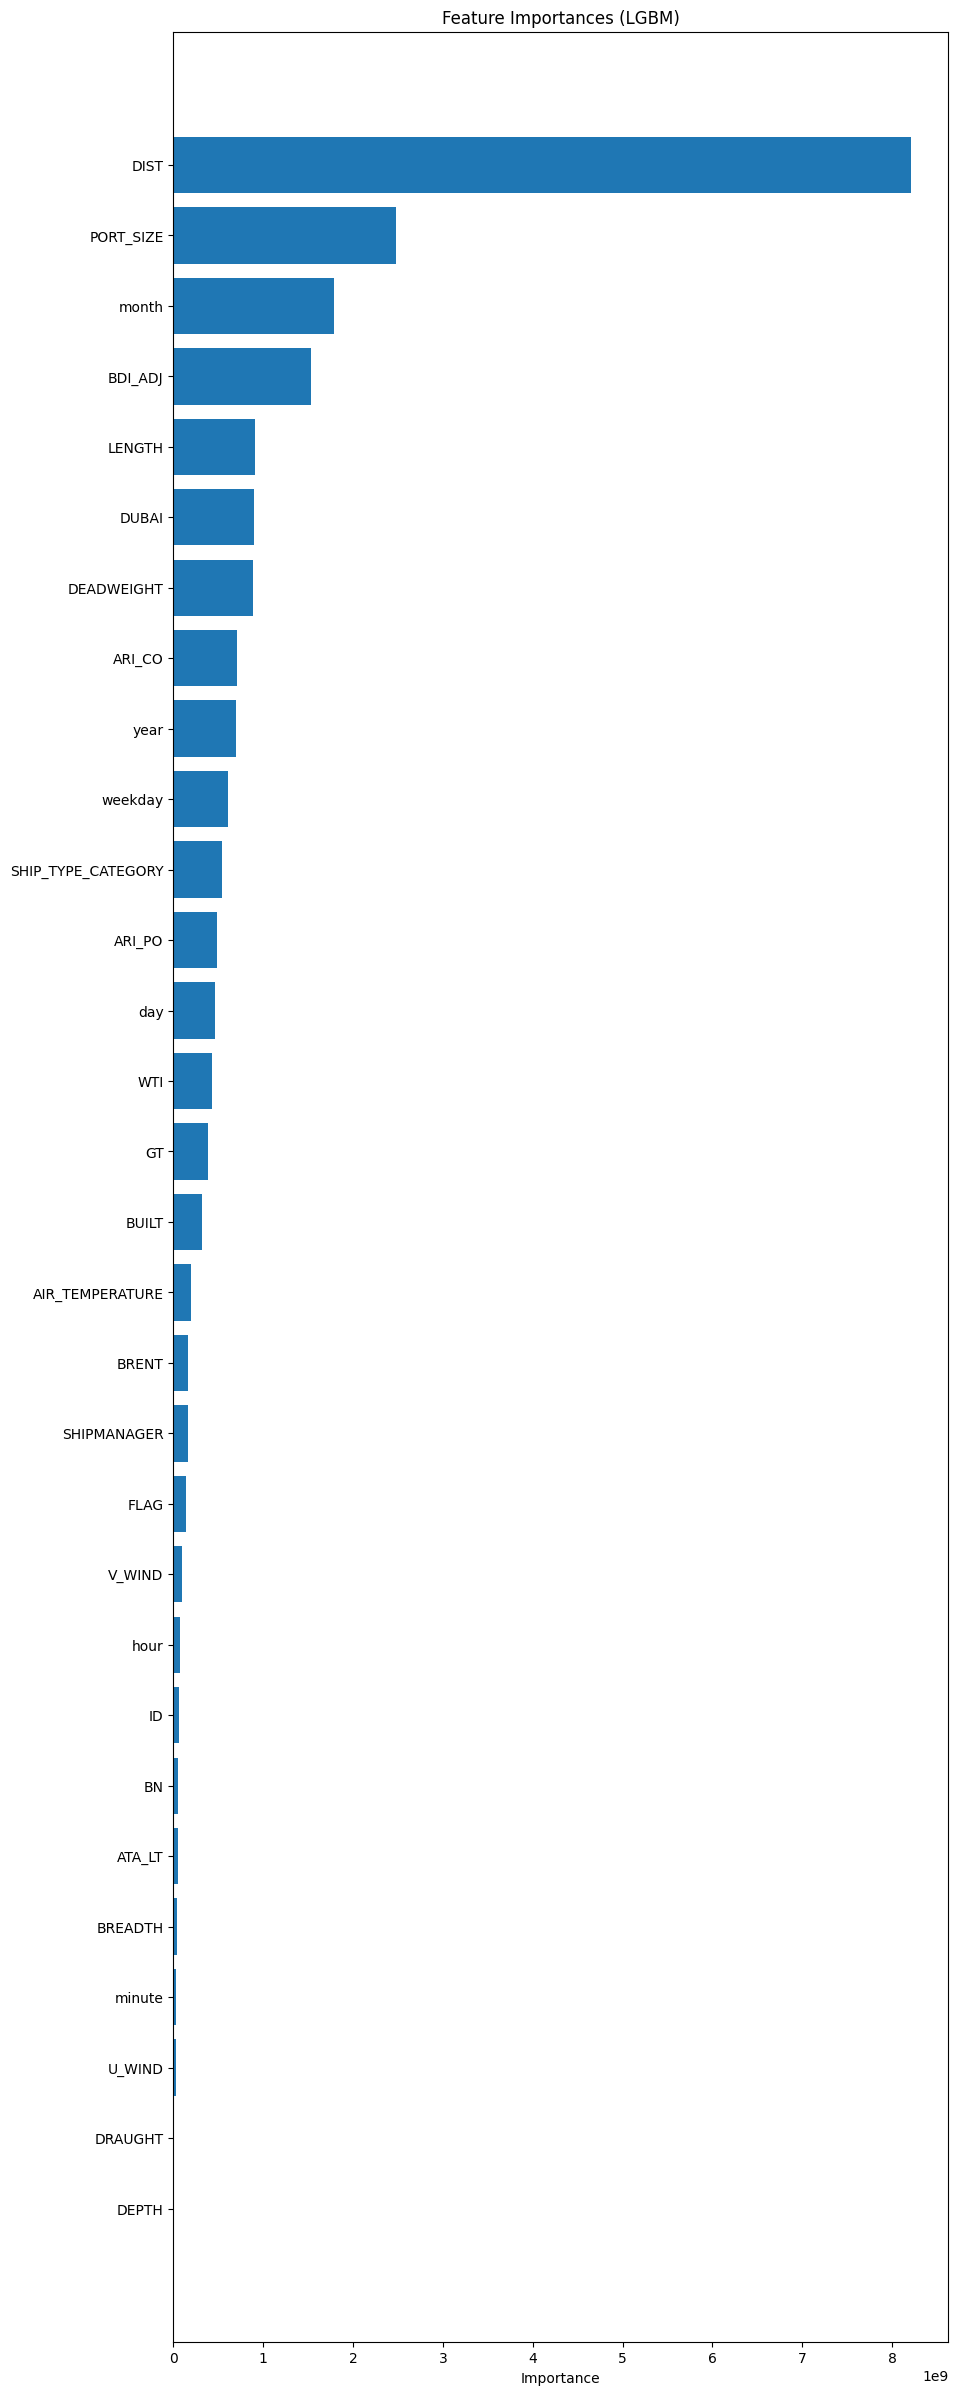

Processing folds:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330696, number of used features: 11
[LightGBM] [Info] Start training from score 61.950857
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  10%|█         | 1/10 [02:45<24:45, 165.08s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.954640
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  20%|██        | 2/10 [05:26<21:44, 163.02s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.874088
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  30%|███       | 3/10 [08:15<19:18, 165.52s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.740460
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  40%|████      | 4/10 [10:58<16:26, 164.48s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.738274
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  50%|█████     | 5/10 [13:40<13:38, 163.67s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.907248
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  60%|██████    | 6/10 [16:22<10:52, 163.10s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.985925
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  70%|███████   | 7/10 [19:05<08:08, 162.99s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.760399
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  80%|████████  | 8/10 [21:46<05:25, 162.61s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 62.042692
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds:  90%|█████████ | 9/10 [24:32<02:43, 163.58s/it]/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 330697, number of used features: 11
[LightGBM] [Info] Start training from score 61.816592
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.

Processing folds: 100%|██████████| 10/10 [27:15<00:00, 163.53s/it]

Validation : MAE scores for each fold: [40.111994955954536, 39.79687468203951, 40.19741519439366, 40.88370405812416, 40.87233388045058, 39.901207525755765, 39.8643744596372, 41.1867001358716, 39.45903232346429, 40.81014227054679]
Validation : MAE: 40.30837794862381


In [ ]:
# Submission_15 (#13 + gain)
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, y_train)

threshold = 0.5e9 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.05, feature_fraction = 0.7, bagging_fraction = 0.7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
# submit.to_csv('submission_13.csv', index=False)

In [ ]:
# Submission_16
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 120 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(max_depth = 30, num_leaves = 1000, num_iterations = 1000, learning_rate = 0.05, feature_fraction = 0.7, bagging_fraction = 0.7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=10, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
# submit.to_csv('submission_13.csv', index=False)

In [ ]:
# bayesian optimizer

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


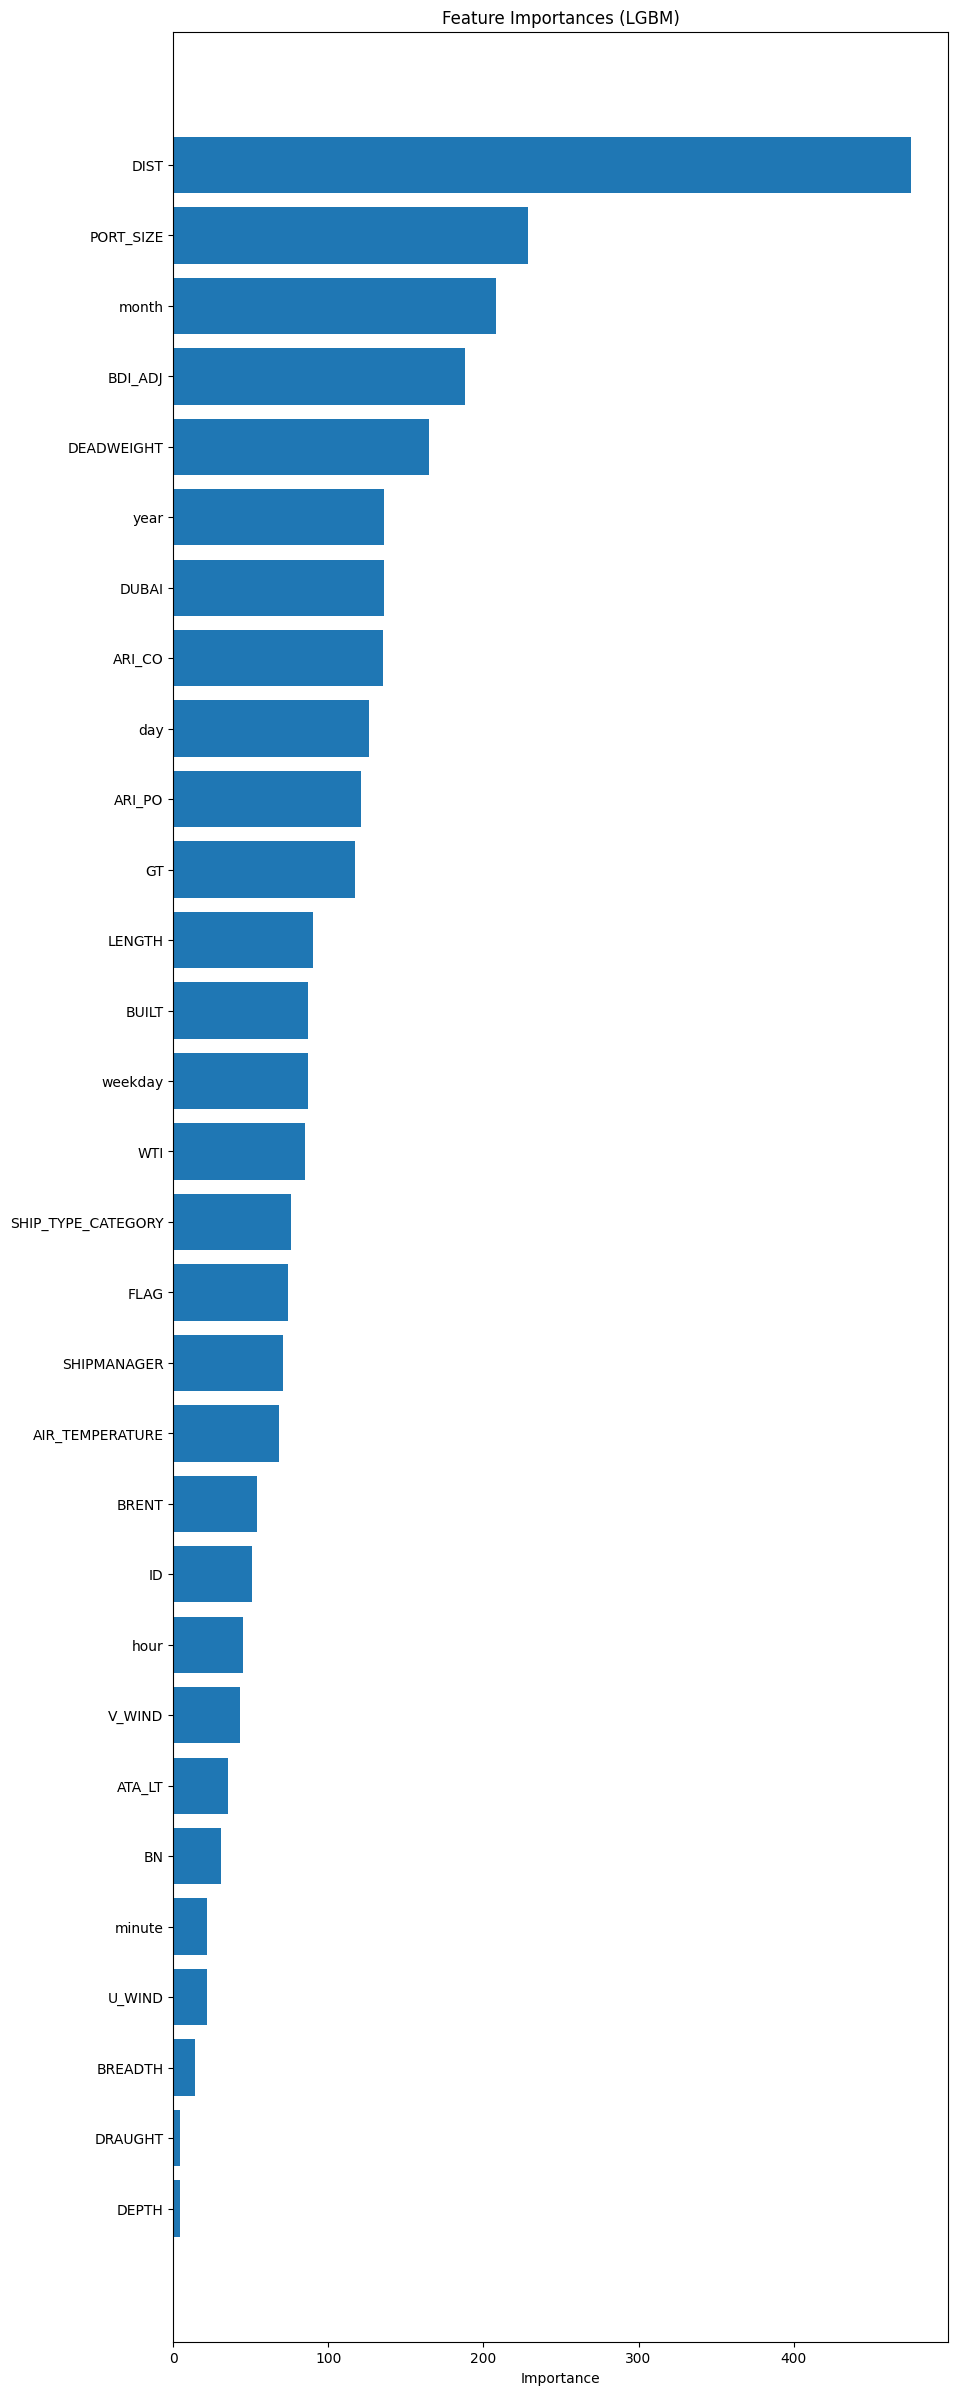

In [ ]:
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

threshold = 80
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
lgbm_parameter_bounds = {
    'n_estimators' : (100, 10000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 5000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 5000),
    'reg_lambda': (0.001, 50),
    'reg_alpha': (0.01, 500),
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'verbose' : -1
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)
  kf = KFold(n_splits=5, shuffle=True, random_state=50)
  scores = []

  for train_idx, val_idx in kf.split(X_train_reduced):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    lgbm.fit(X_t, y_t)
    val_pred = lgbm.predict(X_val)
    scores.append(mean_absolute_error(y_val, val_pred))

  score = 1 / np.mean(scores)
  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 0)
BO_lgbm.maximize(init_points = 30, n_iter = 50)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.02845   | 0.7744    | 0.718     | 3.018e+03 | 27.7      | 429.4     | 323.3     | 4.432e+03 | 4.46e+03  | 481.8     | 19.17     | 0.8959    |
| 2         | 0.04758   | 0.7644    | 0.5724    | 4.629e+03 | 4.481     | 96.26     | 11.09     | 8.343e+03 | 3.893e+03 | 435.0     | 48.93     | 0.8996    |
| 3         | 0.02575   | 0.7307    | 0.7827    | 600.2     | 32.36     | 151.9     | 472.4     | 5.266e+03 | 2.079e+03 | 132.3     | 38.71     | 0.7281    |
| 4         | 0.04346   | 0.7842    | 0.0286    | 3.092e+03 | 30.99     | 620.8     | 471.9     | 6.85e+03  | 1.804e+03 | 218.5     | 34.88     | 0.5301    |
| 5         | 0.04355   | 0.8334    | 0.6739    | 1.

In [ ]:
target_list = []
for result in BO_lgbm.res:
    target = result['target']
    target_list.append(target)
print(target_list)
print('maximum target index:', np.argmax(np.array(target_list)))
max_dict = BO_lgbm.res[np.argmax(np.array(target_list))]
print(max_dict)

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]


Model Tune for XGB.


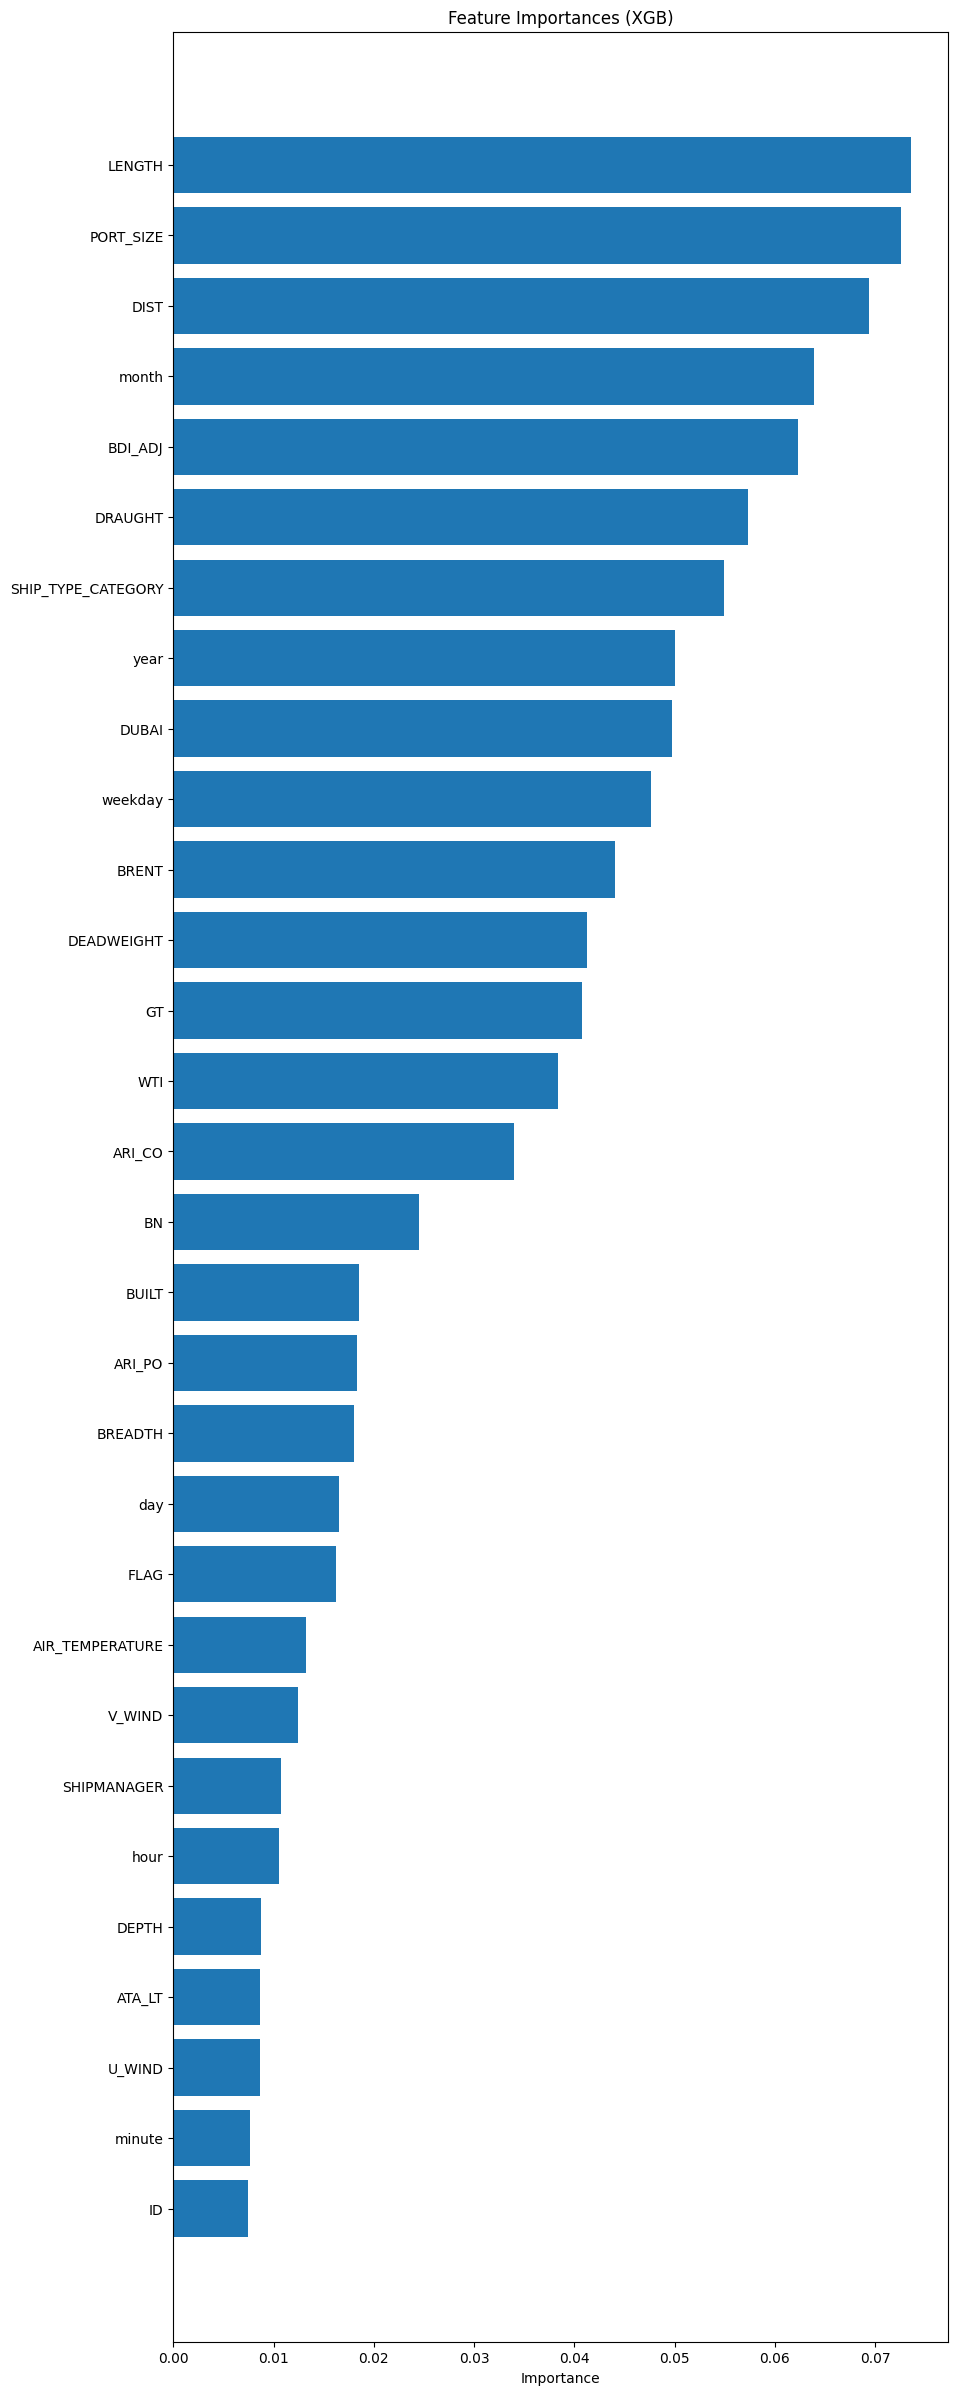

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[09:14:06] WARNING: ../src/learner.cc:767: 
Parameters: { "n_thread" } are not used.

-41.115503054927
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000, 'n_thread': 4, 'subsample': 0.9}


In [ ]:
# XGBOOST & GridSearchCV
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances


from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

xgb_model, xgb_feature_importances = train_and_evaluate(XGBRegressor(), 'XGB', X_train, y_train)


xgb = XGBRegressor()

parameters = {
    'max_depth': [8],
    'n_estimators': [1000],
    'learning_rate': [0.05],
    'colsample_bytree': [0.7, 0.9],
    'subsample': [0.7, 0.9],
    #'min_child_weight': [1, 2, 3, 4, 5],
    #'gamma' : [0, 1, 2, 3, 4],
    #'lambda' : [0, 1, 2, 3, 4],
    #'alpha' : [0, 1, 2, 3, 4],

}

importance = 0.025
low_importance_features = X_train.columns[xgb_feature_importances < importance]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

# seed = 777
# X_tr, X_test, Y_tr, Y_test=train_test_split(X_train,y_train, test_size=0.2, random_state=seed)

xgb_grid = GridSearchCV(xgb, parameters, scoring = 'neg_mean_absolute_error', cv=3, n_jobs=3, verbose=1)
xgb_grid.fit(X_train_reduced, y_train)

scores = pd.DataFrame(xgb_grid.cv_results_)
scores[['params','mean_test_score', 'rank_test_score', 'split0_test_score','split1_test_score', 'split2_test_score']]

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [ ]:
xgb_use = XGBRegressor(max_depth = 8,
    n_estimators = 1000,
    learning_rate = 0.05,
    colsample_bytree = 0.9,
    subsample = 0.9)
model = xgb_use.fit(X_train_reduced, y_train)
xgb_pred = model.predict(X_test_reduced)
xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
submit = pd.read_csv('/content/sample_submission.csv')
submit['CI_HOUR'] = xgb_pred

In [ ]:
submit.to_csv('submission_xgb_1.csv', index=False)

In [ ]:
# 게임 이론 바탕 중요도 산정 (Shapley Value)
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test)
plt.savefig(f'{PATH}/shap.png', dpi=300, bbox_inches="tight")

In [ ]:
# Permutation 기반 중요도 산정
from eli5.lightgbm import *
from eli5.sklearn import *
import eli5

perm = PermutationImportance(model, random_state=42).fit(X_valid, y_valid)
print(eli5.format_as_text(explain_weights.explain_permutation_importance(perm, feature_names = features, top=40)))

explain_weights.explain_permutation_importance(perm, feature_names = features, top=47)

In [ ]:
# GPU 변경
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


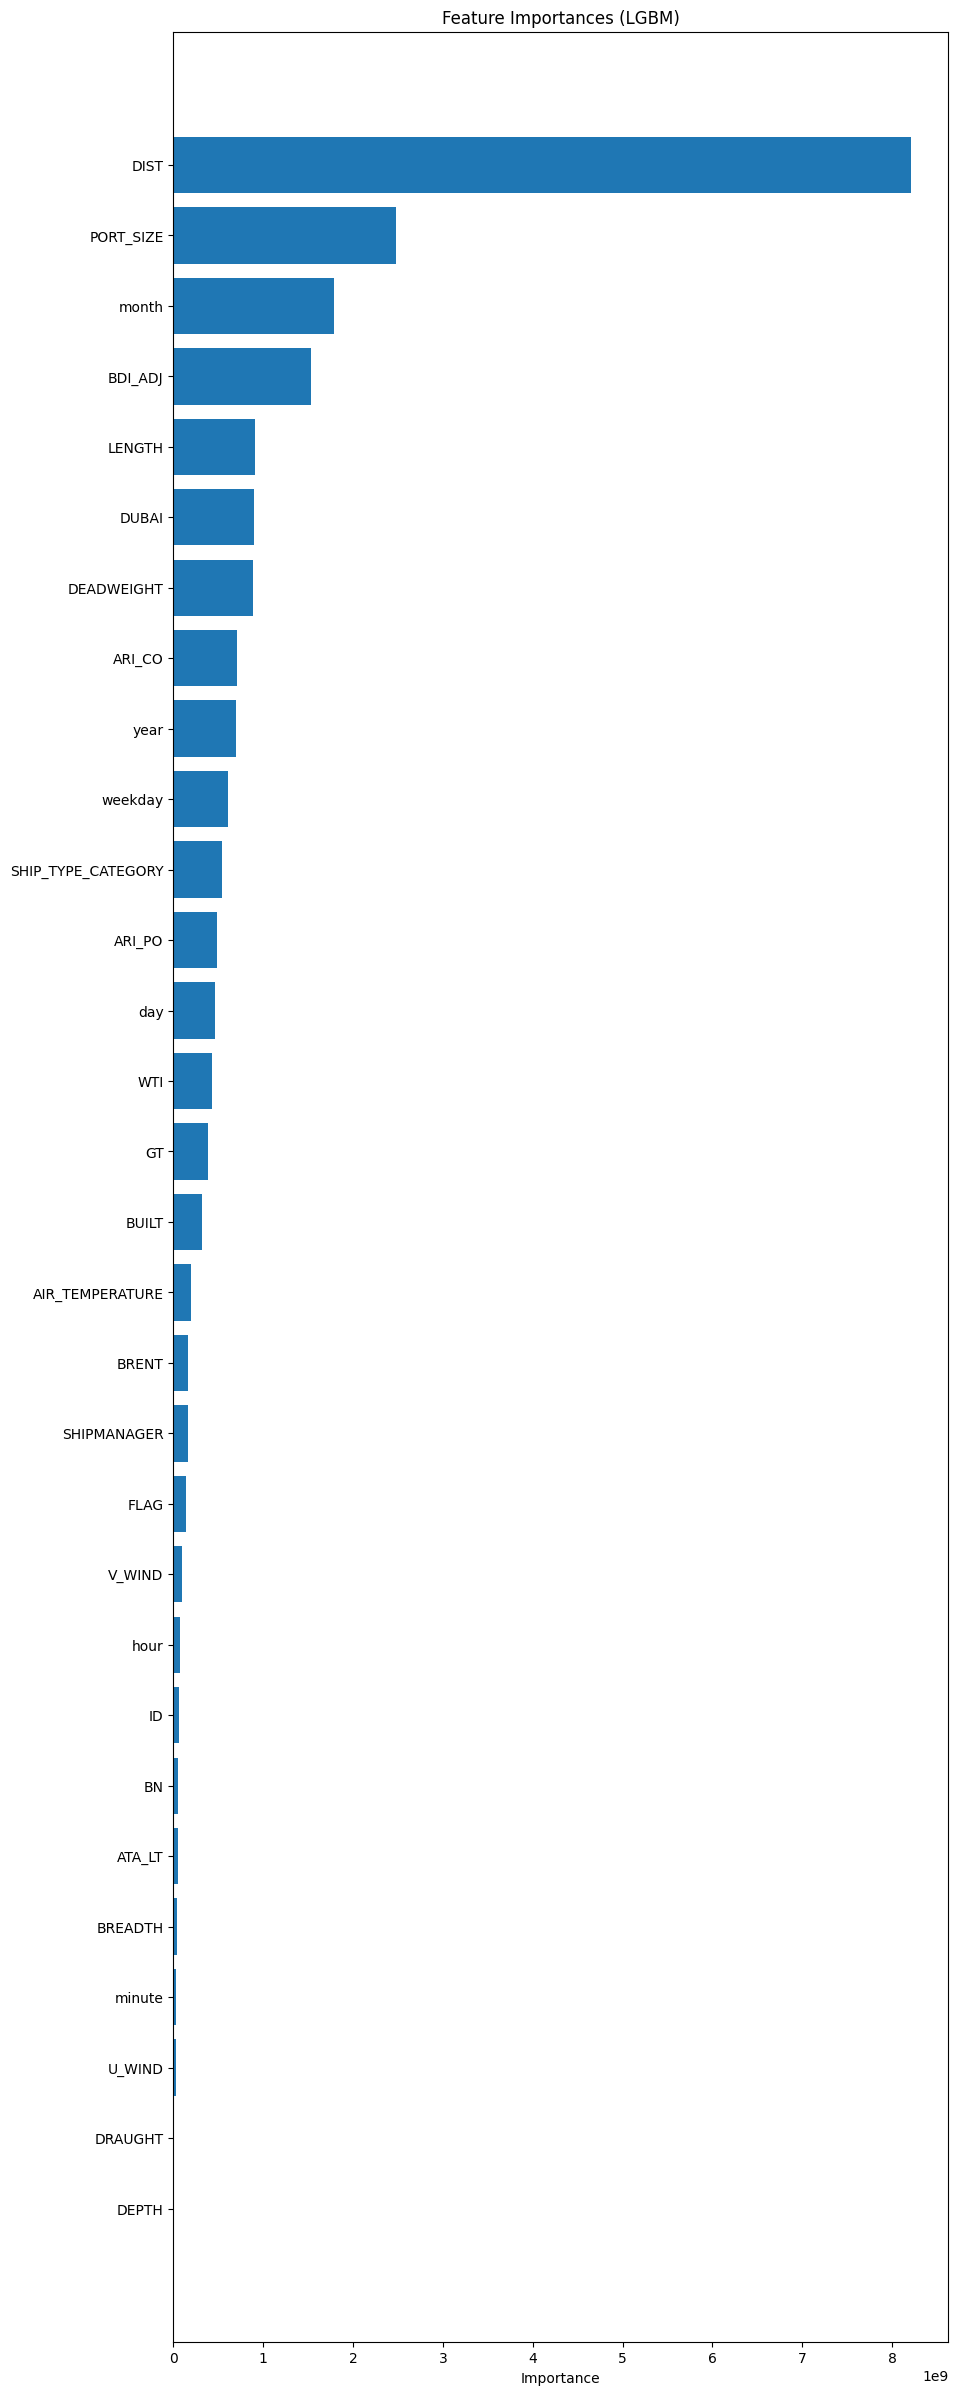

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


Processing folds: 100%|██████████| 5/5 [40:51<00:00, 490.38s/it]


| 1         | 0.03316   | 0.7744    | 0.718     | 6.028e+04 | 27.7      | 429.4     | 323.3     | 8.808e+03 | 4.46e+03  | 963.7     | 38.34     | 0.8959    |


Processing folds: 100%|██████████| 5/5 [46:29<00:00, 557.89s/it]


| 2         | 0.05979   | 0.7644    | 0.5724    | 9.256e+04 | 4.481     | 96.26     | 11.09     | 1.667e+04 | 3.893e+03 | 870.0     | 97.86     | 0.8996    |


Processing folds: 100%|██████████| 5/5 [59:47<00:00, 717.57s/it]


| 3         | 0.03108   | 0.7307    | 0.7827    | 1.184e+04 | 32.36     | 151.9     | 472.4     | 1.048e+04 | 2.079e+03 | 264.6     | 77.42     | 0.7281    |


Processing folds: 100%|██████████| 5/5 [5:10:02<00:00, 3720.52s/it]


| 4         | 0.05085   | 0.7842    | 0.0286    | 6.177e+04 | 30.99     | 620.8     | 471.9     | 1.367e+04 | 1.804e+03 | 437.0     | 69.76     | 0.5301    |


Processing folds: 100%|██████████| 5/5 [31:59<00:00, 383.89s/it]


| 5         | 0.04797   | 0.8334    | 0.6739    | 2.105e+04 | 7.317     | 322.3     | 182.5     | 1.145e+04 | 2.199e+03 | 988.4     | 10.21     | 0.6044    |


Processing folds:  20%|██        | 1/5 [09:26<37:45, 566.43s/it]

In [ ]:
# 실행해야 할 코드

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
# bayesian optimizer

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, y_train)

threshold = 0.4e9
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm_parameter_bounds = {
    'n_estimators' : (100, 20000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 5000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 100000),
    'reg_lambda': (0.001, 500),
    'reg_alpha': (0.01, 1000),
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'verbose' : -1,
      'num_threads' : 3
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)
  kf = KFold(n_splits=5, shuffle=True, random_state=50)
  scores = []

  for train_idx, val_idx in tqdm(kf.split(X_train_reduced),total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    lgbm.fit(X_t, y_t)
    val_pred = lgbm.predict(X_val)
    scores.append(mean_absolute_error(y_val, val_pred))

  score = 1 / np.mean(scores)
  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 0)
BO_lgbm.maximize(init_points = 20, n_iter = 40)

# JAVASCRIPT CODE
#function ClickConnect(){
    #console.log("코랩 연결 끊김 방지");
    #document.querySelector("colab-toolbar-button#connect").click()
#}
#setInterval(ClickConnect, 60 * 1000)

Encoding features: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


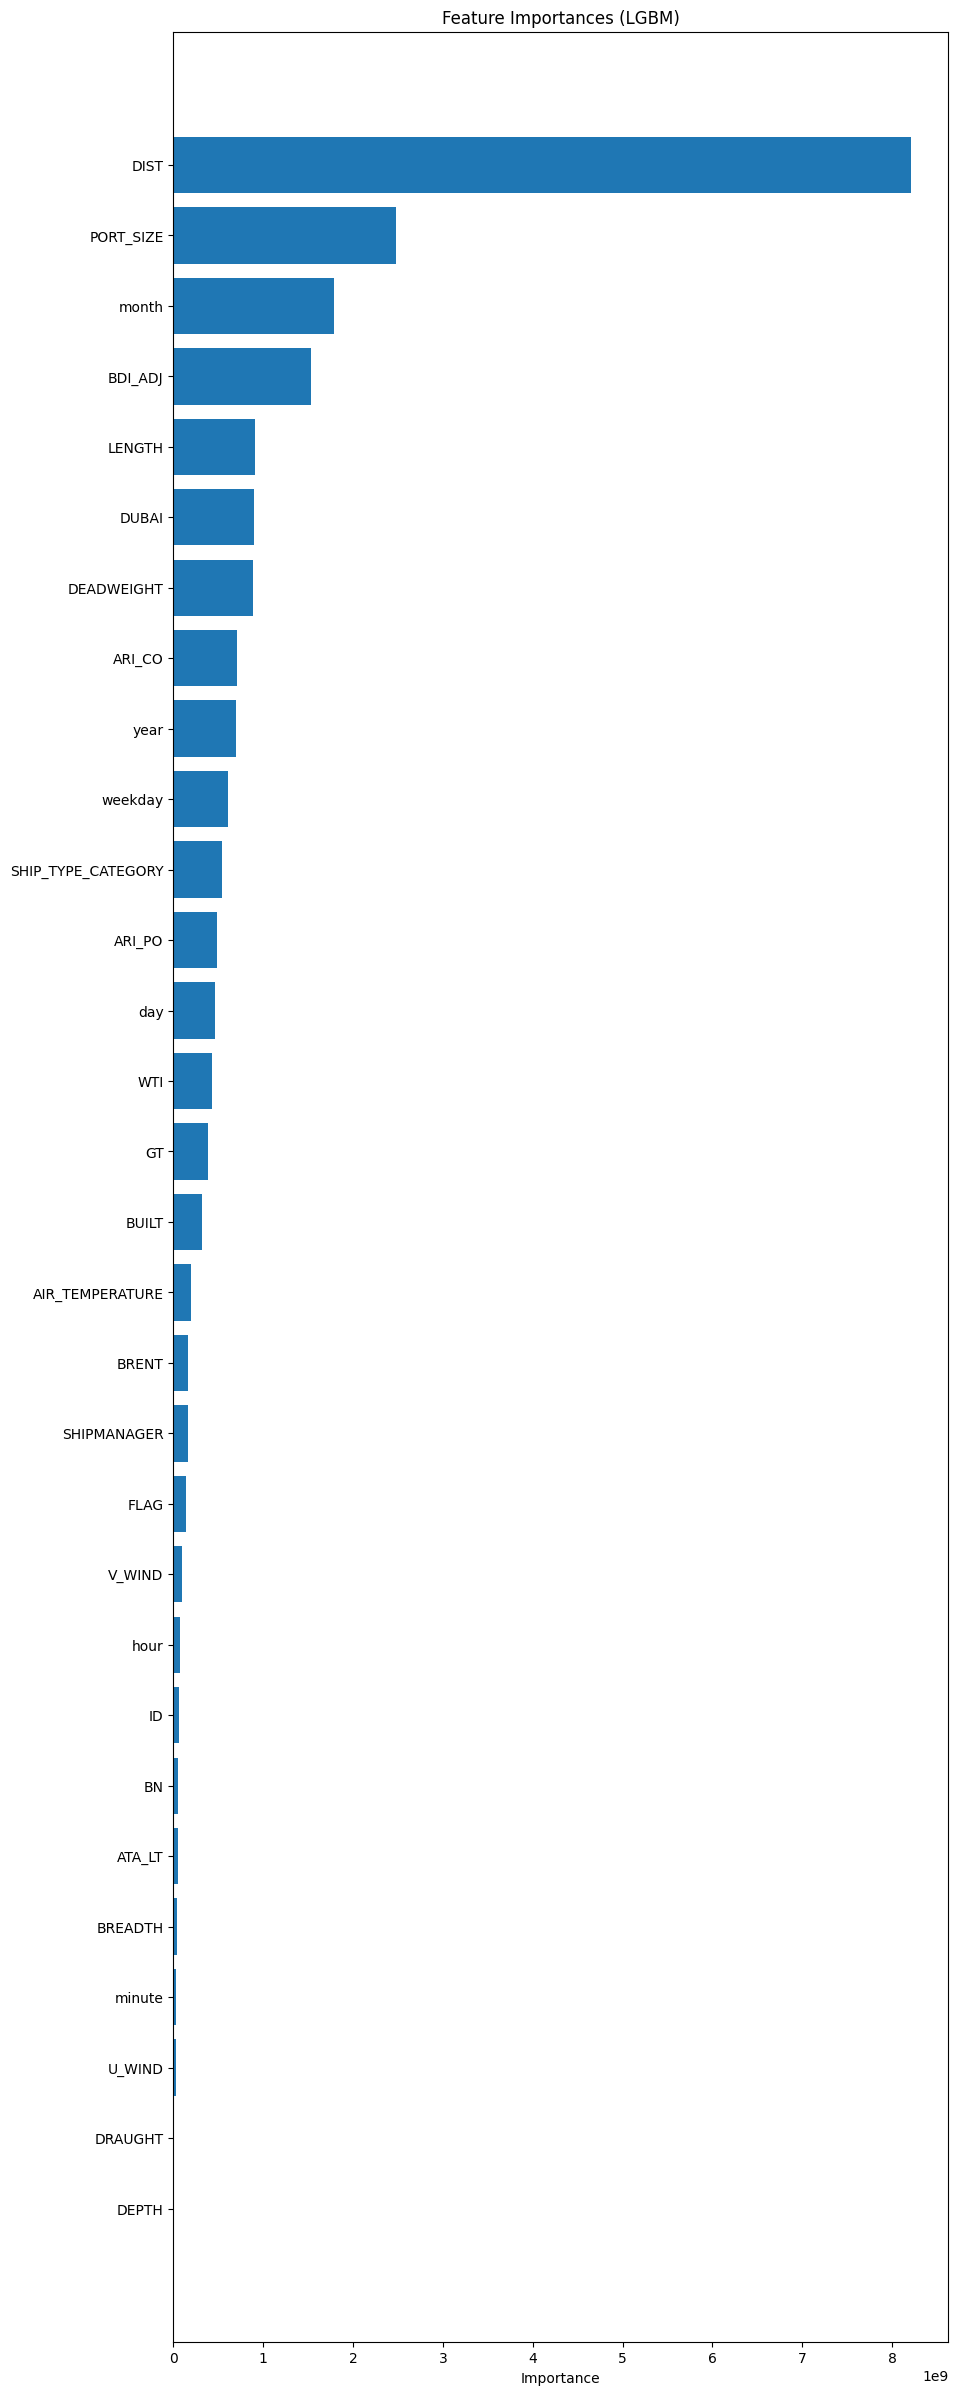

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.03673   | 0.7744    | 0.718     | 1.206e+05 | 27.7      | 429.4     | 323.3     | 8.808e+03 | 4.46e+03  | 963.7     | 191.7     | 0.8959    |
| 2         | 0.06151   | 0.7644    | 0.5724    | 1.851e+05 | 4.481     | 96.26     | 11.09     | 1.667e+04 | 3.893e+03 | 870.0     | 489.3     | 0.8996    |
| 3         | 0.03903   | 0.7307    | 0.7827    | 2.366e+04 | 32.36     | 151.9     | 472.4     | 1.048e+04 | 2.079e+03 | 264.6     | 387.1     | 0.7281    |
| 4         | 0.0514    | 0.7842    | 0.0286    | 1.235e+05 | 30.99     | 620.8     | 471.9     | 1.367e+04 | 1.804e+03 | 437.0     | 348.8     | 0.5301    |
| 5         | 0.04919   | 0.8334    | 0.6739    | 4.

In [ ]:
# 실행해야 할 코드 2 (Not using Kfold)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
# bayesian optimizer

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, y_train)

threshold = 0.4e9
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

lgbm_parameter_bounds = {
    'n_estimators' : (100, 50000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 5000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 500000),
    'reg_lambda': (0.001, 500),
    'reg_alpha': (0.01, 1000),
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'verbose' : -1,
      'num_threads' : 4
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)

  seed = 777
  X_tr, X_test, Y_tr, Y_test=train_test_split(X_train_reduced,y_train,test_size=0.2, random_state=seed)

  lgbm.fit(X_tr, Y_tr)

  val_pred = lgbm.predict(X_test)
  scores = (mean_absolute_error(Y_test, val_pred))
  score = 1 / scores

  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 0)
BO_lgbm.maximize(init_points = 20, n_iter = 40)

# JAVASCRIPT CODE
#function ClickConnect(){
    #console.log("코랩 연결 끊김 방지");
    #document.querySelector("colab-toolbar-button#connect").click()
#}
#setInterval(ClickConnect, 60 * 1000)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(train.mode().iloc[0], inplace=True)
#train.dropna(axis=0)
#test.dropna(axis=0)

Encoding features: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


In [ ]:
condition_train_nz = (train['DIST'] != 0)
condition_train_z = (train['DIST'] == 0)
condition_test_nz = (test['DIST'] != 0)
condition_test_z = (test['DIST'] == 0)

train_nz = train.loc[condition_train_nz]
train_z = train.loc[condition_train_z]
test_nz = test.loc[condition_test_nz]
test_z = test.loc[condition_test_z]

train_nz_sample = train_nz['SAMPLE_ID']
train_z_sample = train_z['SAMPLE_ID']
test_nz_sample = list(test_nz['SAMPLE_ID'])
test_z_sample = list(test_z['SAMPLE_ID'])

submit_z_data = {'SAMPLE_ID' : test_z_sample,
                'CI_HOUR' : 0}
submit_z = pd.DataFrame(submit_z_data)


train_nz = train_nz.drop(columns=['SAMPLE_ID'])
test_nz = test_nz.drop(columns=['SAMPLE_ID'])

X_train_nz = train_nz.drop(columns=['CI_HOUR'])
Y_train_nz = train_nz['CI_HOUR']

KeyError: ignored

In [ ]:
X_train_nz['AIR_TEMPERATURE'] = X_train_nz['AIR_TEMPERATURE'] + 50
test_nz['AIR_TEMPERATURE'] = test_nz['AIR_TEMPERATURE'] + 50

dist_log_train = list(np.log(X_train_nz['DIST']))
dist_log_test = list(np.log(test_nz['DIST']))
deadweight_log_train = list(np.log(X_train_nz['DEADWEIGHT']))
deadweight_log_test = list(np.log(test_nz['DEADWEIGHT']))
gt_log_train = list(np.log(X_train_nz['GT']))
gt_log_test = list(np.log(test_nz['GT']))
air_log_train = list(np.log(X_train_nz['AIR_TEMPERATURE']))
air_log_test = list(np.log(test_nz['AIR_TEMPERATURE']))

X_train_nz_data = {'ARI_CO':list(X_train_nz['ARI_CO']),
                   'ARI_PO':list(X_train_nz['ARI_PO']),
                   'SHIP_TYPE_CATEGORY':list(X_train_nz['SHIP_TYPE_CATEGORY']),
                   'DIST':dist_log_train,
                   'year':list(X_train_nz['year']),
                   'month':list(X_train_nz['month']),
                   'day':list(X_train_nz['day']),
                   'hour':list(X_train_nz['hour']),
                   'minute':list(X_train_nz['minute']),
                   'weekday':list(X_train_nz['weekday']),
                   'ID':list(X_train_nz['ID']),
                   'BREADTH':list(X_train_nz['BREADTH']),
                   'BUILT':list(X_train_nz['BUILT']),
                   'DEADWEIGHT':deadweight_log_train,
                   'DEPTH':list(X_train_nz['DEPTH']),
                   'DRAUGHT':list(X_train_nz['DRAUGHT']),
                   'GT':gt_log_train,
                   'LENGTH':list(X_train_nz['LENGTH']),
                   'SHIPMANAGER':list(X_train_nz['SHIPMANAGER']),
                   'FLAG':list(X_train_nz['FLAG']),
                   'U_WIND':list(X_train_nz['U_WIND']),
                   'V_WIND':list(X_train_nz['V_WIND']),
                   'AIR_TEMPERATURE':air_log_train,
                   'BN':list(X_train_nz['BN']),
                   'ATA_LT':list(X_train_nz['ATA_LT']),
                   'PORT_SIZE':list(X_train_nz['PORT_SIZE'])}

test_nz_data = {'ARI_CO':list(test_nz['ARI_CO']),
                'ARI_PO':list(test_nz['ARI_PO']),
                'SHIP_TYPE_CATEGORY':list(test_nz['SHIP_TYPE_CATEGORY']),
                'DIST':dist_log_test,
                'year':list(test_nz['year']),
                'month':list(test_nz['month']),
                'day':list(test_nz['day']),
                'hour':list(test_nz['hour']),
                'minute':list(test_nz['minute']),
                'weekday':list(test_nz['weekday']),
                'ID':list(test_nz['ID']),
                'BREADTH':list(test_nz['BREADTH']),
                'BUILT':list(test_nz['BUILT']),
                'DEADWEIGHT':deadweight_log_test,
                'DEPTH':list(test_nz['DEPTH']),
                'DRAUGHT':list(test_nz['DRAUGHT']),
                'GT':gt_log_test,
                'LENGTH':list(test_nz['LENGTH']),
                'SHIPMANAGER':list(test_nz['SHIPMANAGER']),
                'FLAG':list(test_nz['FLAG']),
                'U_WIND':list(test_nz['U_WIND']),
                'V_WIND':list(test_nz['V_WIND']),
                'AIR_TEMPERATURE':air_log_test,
                'BN':list(test_nz['BN']),
                'ATA_LT':list(test_nz['ATA_LT']),
                'PORT_SIZE':list(test_nz['PORT_SIZE'])}

X_train_nz_final = pd.DataFrame(X_train_nz_data)
test_nz_final = pd.DataFrame(test_nz_data)


In [ ]:
Y_train_log = list(np.log(Y_train_nz))
Y_train_nz_data = {'CI_HOUR':Y_train_log}
Y_train_nz_final = pd.DataFrame(Y_train_nz_data)

In [ ]:
cat_list = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG', 'weekday', 'year', 'hour', 'month', 'day']
for col in cat_list :
    X_train_nz_final[col] = X_train_nz_final[col].astype('category')
    test_nz_final[col] = test_nz_final[col].astype('category')

In [ ]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 61.940835


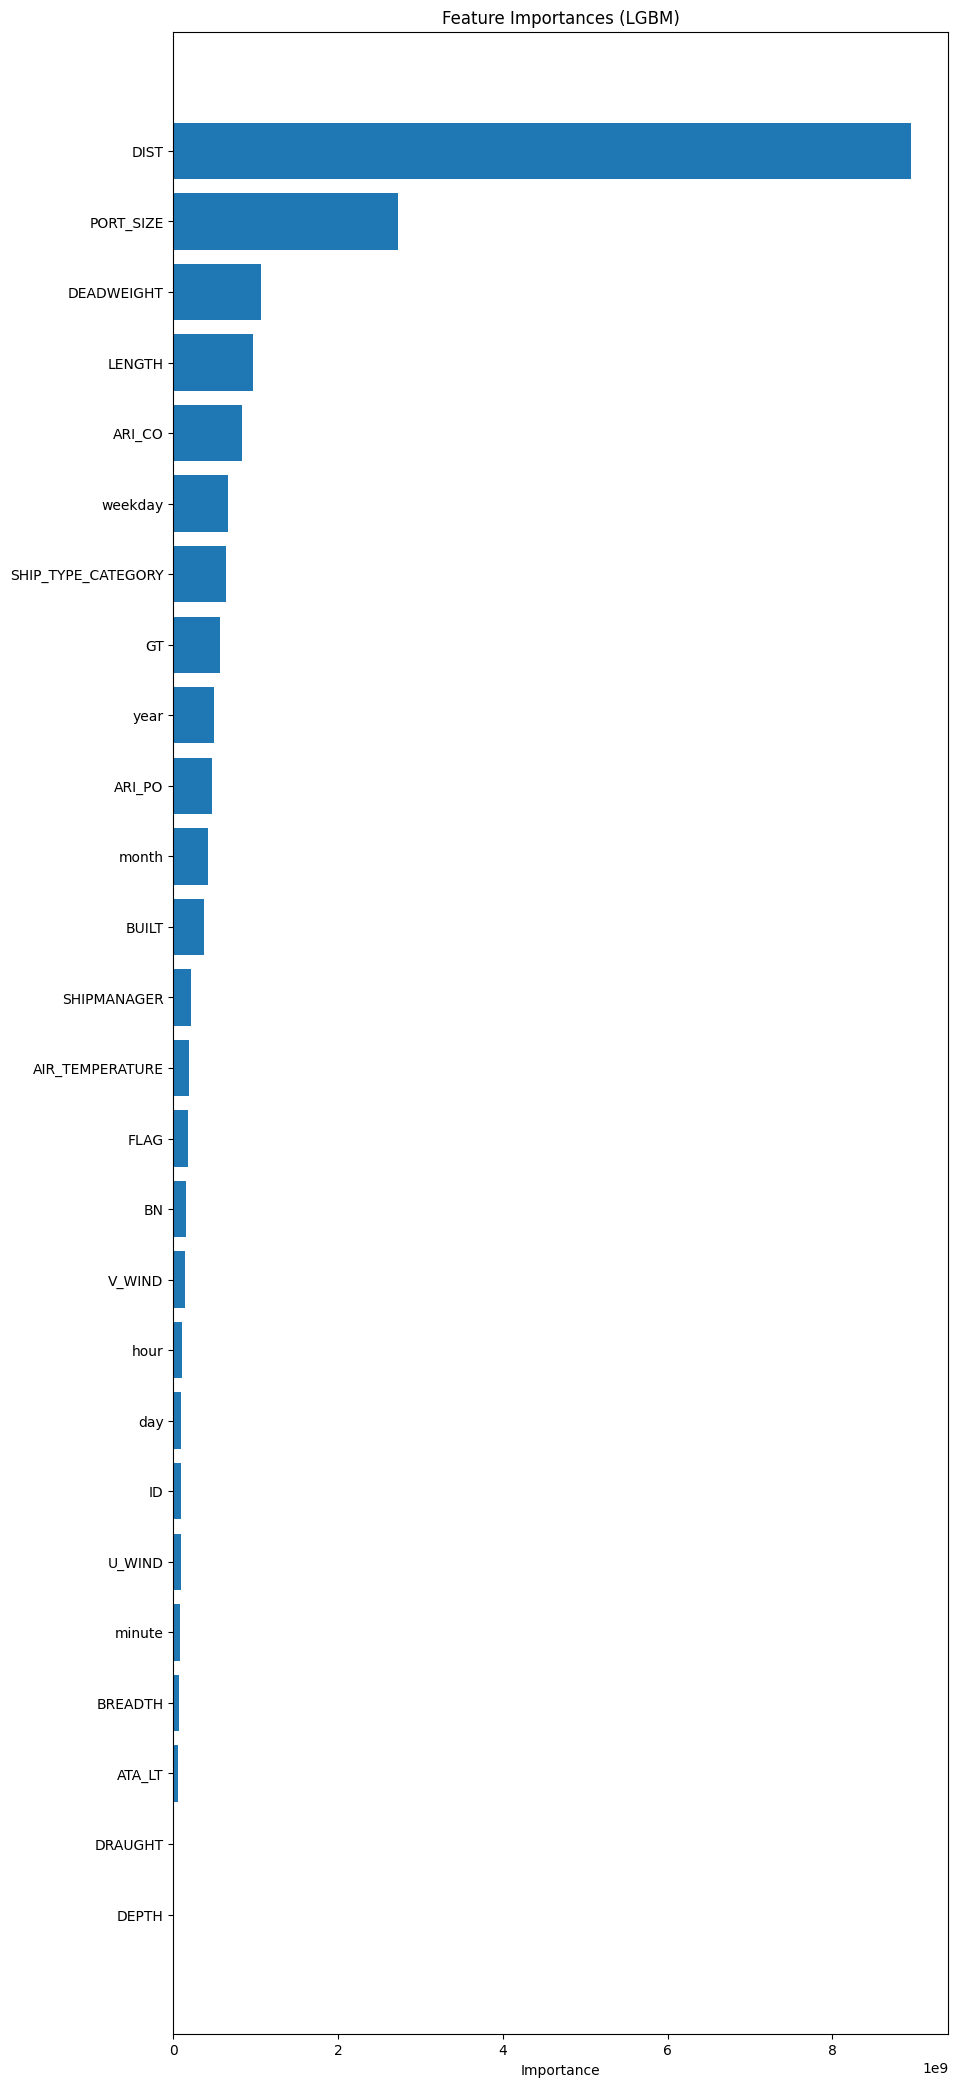

In [ ]:
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type='gain'), 'LGBM', X_train, y_train)

In [ ]:
threshold = 0.2e9
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

In [ ]:
print(X_train_reduced)

        ARI_CO  ARI_PO  SHIP_TYPE_CATEGORY       DIST  BUILT  DEADWEIGHT  \
0           17      21                   2  30.881018     24       24300   
1            7      81                   0   0.000000     13       35900   
2            4      14                   2   0.000000     12      146000   
3            8     101                   2   0.000000     18        6910   
4           17      21                   2  27.037650     10      116000   
...        ...     ...                 ...        ...    ...         ...   
391934       8      66                   2   0.000000     27        6820   
391935      17      21                   0   5.884603     12        3160   
391936      21      61                   0  70.660241      8       60300   
391937      19      35                   2   9.448179     29       23800   
391938      19      35                   2   0.000000     15       50600   

            GT  LENGTH  SHIPMANAGER  PORT_SIZE  year  month  weekday  
0        16700  

In [ ]:
X_train_reduced.dtypes

ARI_CO                  int64
ARI_PO                  int64
SHIP_TYPE_CATEGORY      int64
DIST                  float64
BUILT                   int64
DEADWEIGHT              int64
GT                      int64
LENGTH                float64
SHIPMANAGER             int64
PORT_SIZE             float64
year                    int64
month                   int64
weekday                 int64
dtype: object

In [ ]:
Y_train_nz_final.dtypes
print(Y_train_nz_final)

         CI_HOUR
0       1.238374
1       5.535579
2       4.225247
3       3.456334
4       4.063766
...          ...
234641  4.498522
234642  6.999055
234643  4.970240
234644  3.725265
234645  2.012938

[234646 rows x 1 columns]


In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
lgbm_parameter_bounds = {
    'n_estimators' : (100, 30000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 1000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 30000),
    'reg_lambda': (0, 100),
    'reg_alpha': (0, 100),
    'subsample_freq' : (0, 10)
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha, subsample_freq):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'subsample_freq' : int(round(subsample_freq)),
      'verbose' : -1,
      'num_threads' : 4,
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)

  seed = 777
  X_tr, X_test, Y_tr, Y_test=train_test_split(X_train_reduced,y_train,test_size=0.2, random_state=seed)

  lgbm.fit(X_tr, Y_tr)

  val_pred = lgbm.predict(X_test)
  scores = (mean_absolute_error(Y_test, val_pred))
  score = 1 / scores

  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 0)
BO_lgbm.maximize(init_points = 20, n_iter = 40)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.01139   | 0.7744    | 0.718     | 1.809e+04 | 27.7      | 429.4     | 323.3     | 1.318e+04 | 892.9     | 96.37     | 38.34     | 0.8959    | 5.289     |
| 2         | 0.01116   | 0.784     | 0.9263    | 2.14e+03  | 5.269     | 30.02     | 416.5     | 2.337e+04 | 871.3     | 97.86     | 79.92     | 0.7307    | 7.805     |
| 3         | 0.009636  | 0.5591    | 0.6435    | 4.309e+03 | 47.29     | 526.6     | 207.9     | 8.01e+03  | 776.5     | 45.62     | 56.84     | 0.5094    | 6.176     |
| 4         | 0.01078   | 0.806     | 0.6208    | 2.831e+04 | 34.41     | 365.9     | 219.1     | 2.096e+04 | 69.62     | 66.68     | 67.06     | 0.60

In [ ]:
!pip install catboost
import catboost as cat
from catboost import CatBoostRegressor
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.6 MB/s eta 0:00:00


ModuleNotFoundError: ignored

- threshold : 120, lr : 0.05, fr : 0.7, bf : 0.7, MAE : 28.9642 #10
- threshold : 120, lr : 0.02, fr : 0.7, bf : 0.7, MAE : 31.16
- threshold : 120, lr : 0.02, fr : 0.7, bf : 0.7, kfold : 10 MAE : 30.2 #11
- threshold : 120, lr : 0.02, fr : 0.9, bf : 0.9, kfold : 10 MAE : 30.38 #12
- threshold : 120, lr : 0.05, fr : 0.7, bf : 0.7, kfold : 10 MAE : 27.75 #13
- threshold : 0.4e9, lr : 0.05, fr : 0.7, bf : 0.7, kfold : 10 MAE : 28.22 #14
- threshold : 0.5e9, lr : 0.05, fr : 0.7, bf : 0.7, kfold : 10 MAE : 40.31 #15
- threshold : 0.5e9, lr : 0.05, fr : 0.7, bf : 0.7, kfold : 10 MAE : 40.31 #16

Encoding features: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Model Tune for LGBM.
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22818
[LightGBM] [Info] Number of data points in the train set: 234646, number of used features: 19
[LightGBM] [Info] Start training from score 3.524462


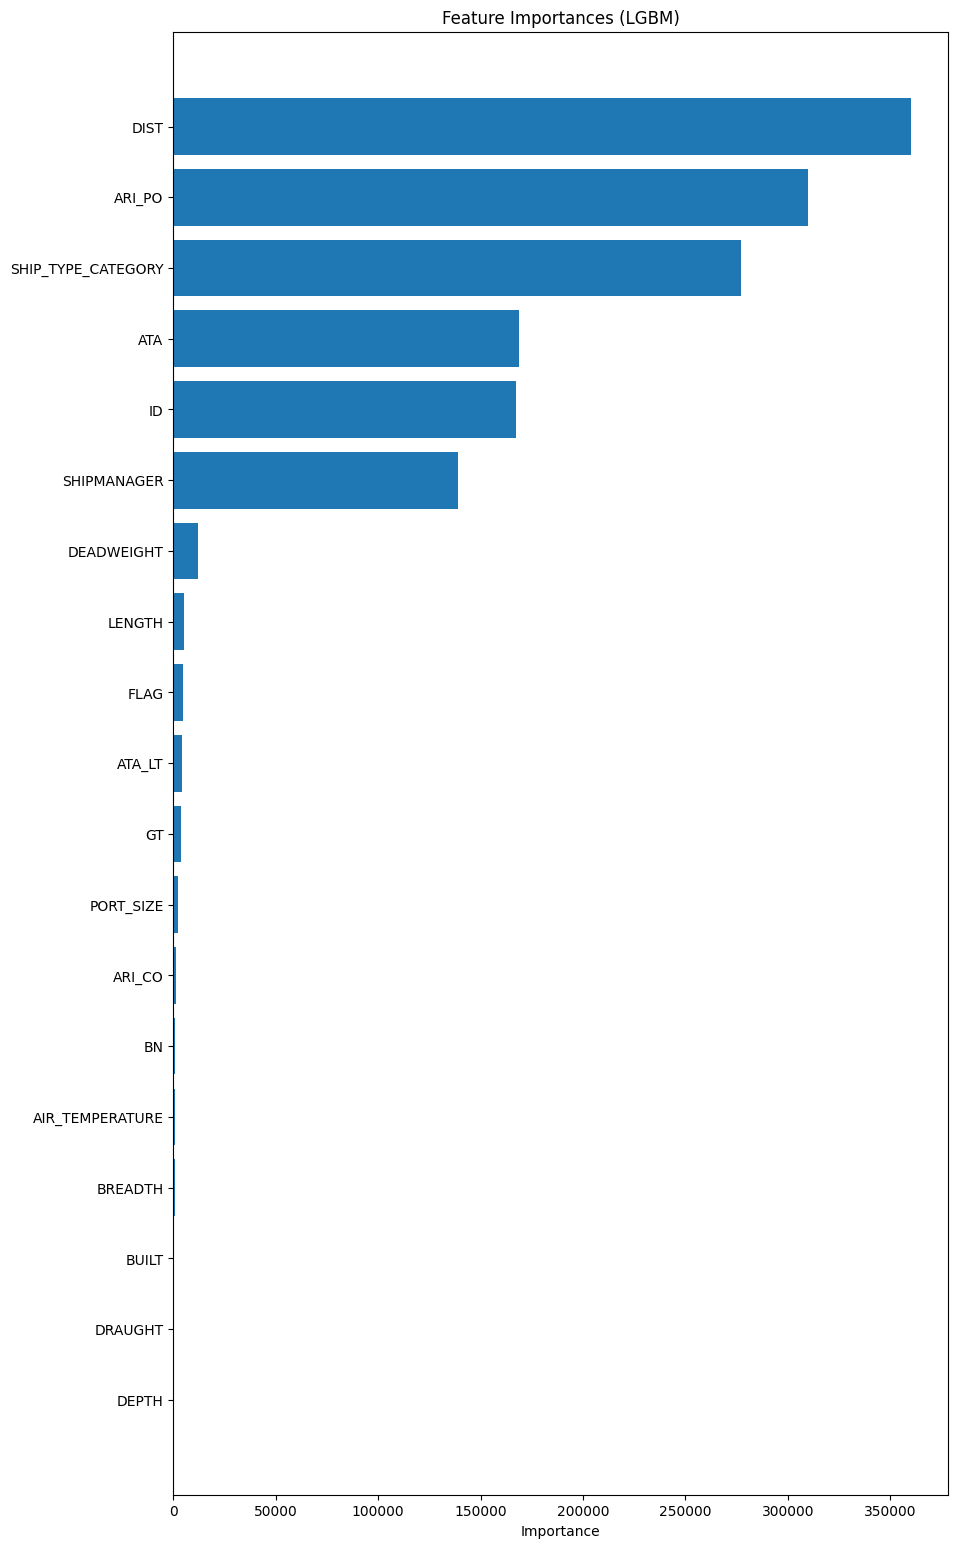

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')


# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])


# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['ATA_NEW'] = df['ATA'].dt.year * df['ATA'].dt.month * df['ATA'].dt.day
    #df['month'] = df['ATA'].dt.month
    #df['day'] = df['ATA'].dt.day
    #df['hour'] = df['ATA'].dt.hour
    #df['minute'] = df['ATA'].dt.minute
    #df['weekday'] = df['ATA'].dt.weekday


# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)


# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG', 'ATA_NEW']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(train.mode().iloc[0], inplace=True)
#train.dropna(axis=0, inplace=True)
#test.dropna(axis=0, inplace=True)

"""
# BN이 0인 값 학습 제외
condition_bn = (train['BN'] != 0)
train = train.loc[condition_bn]
"""

condition_train_nz = (train['DIST'] != 0)
condition_train_z = (train['DIST'] == 0)
condition_test_nz = (test['DIST'] != 0)
condition_test_z = (test['DIST'] == 0)

train_nz = train.loc[condition_train_nz]
train_z = train.loc[condition_train_z]
test_nz = test.loc[condition_test_nz]
test_z = test.loc[condition_test_z]

train_nz_sample = train_nz['SAMPLE_ID']
train_z_sample = train_z['SAMPLE_ID']
test_nz_sample = list(test_nz['SAMPLE_ID'])
test_z_sample = list(test_z['SAMPLE_ID'])

submit_z_data = {'SAMPLE_ID' : test_z_sample,
                'CI_HOUR' : 0}
submit_z = pd.DataFrame(submit_z_data)


train_nz = train_nz.drop(columns=['SAMPLE_ID'])
test_nz = test_nz.drop(columns=['SAMPLE_ID'])

X_train_nz = train_nz.drop(columns=['CI_HOUR'])
Y_train_nz = train_nz['CI_HOUR']

X_train_nz['AIR_TEMPERATURE'] = X_train_nz['AIR_TEMPERATURE'] + 50
test_nz['AIR_TEMPERATURE'] = test_nz['AIR_TEMPERATURE'] + 50

dist_log_train = list(np.log(X_train_nz['DIST']))
dist_log_test = list(np.log(test_nz['DIST']))
deadweight_log_train = list(np.log(X_train_nz['DEADWEIGHT']))
deadweight_log_test = list(np.log(test_nz['DEADWEIGHT']))
gt_log_train = list(np.log(X_train_nz['GT']))
gt_log_test = list(np.log(test_nz['GT']))
air_log_train = list(np.log(X_train_nz['AIR_TEMPERATURE']))
air_log_test = list(np.log(test_nz['AIR_TEMPERATURE']))

X_train_nz_data = {'ARI_CO':list(X_train_nz['ARI_CO']),
                   'ARI_PO':list(X_train_nz['ARI_PO']),
                   'SHIP_TYPE_CATEGORY':list(X_train_nz['SHIP_TYPE_CATEGORY']),
                   'DIST':dist_log_train,
                   'ATA':list(X_train_nz['ATA_NEW']),
                   #'year':list(X_train_nz['year']),
                   #'month':list(X_train_nz['month']),
                   #'day':list(X_train_nz['day']),
                   #'hour':list(X_train_nz['hour']),
                   #'minute':list(X_train_nz['minute']),
                   #'weekday':list(X_train_nz['weekday']),
                   'ID':list(X_train_nz['ID']),
                   'BREADTH':list(X_train_nz['BREADTH']),
                   'BUILT':list(X_train_nz['BUILT']),
                   'DEADWEIGHT':deadweight_log_train,
                   'DEPTH':list(X_train_nz['DEPTH']),
                   'DRAUGHT':list(X_train_nz['DRAUGHT']),
                   'GT':gt_log_train,
                   'LENGTH':list(X_train_nz['LENGTH']),
                   'SHIPMANAGER':list(X_train_nz['SHIPMANAGER']),
                   'FLAG':list(X_train_nz['FLAG']),
                   #'U_WIND':list(X_train_nz['U_WIND']),
                   #'V_WIND':list(X_train_nz['V_WIND']),
                   'AIR_TEMPERATURE':air_log_train,
                   'BN':list(X_train_nz['BN']),
                   'ATA_LT':list(X_train_nz['ATA_LT']),
                   'PORT_SIZE':list(X_train_nz['PORT_SIZE'])}

test_nz_data = {'ARI_CO':list(test_nz['ARI_CO']),
                'ARI_PO':list(test_nz['ARI_PO']),
                'SHIP_TYPE_CATEGORY':list(test_nz['SHIP_TYPE_CATEGORY']),
                'DIST':dist_log_test,
                'ATA':list(test_nz['ATA_NEW']),
                #'year':list(test_nz['year']),
                #'month':list(test_nz['month']),
                #'day':list(test_nz['day']),
                #'hour':list(test_nz['hour']),
                #'minute':list(test_nz['minute']),
                #'weekday':list(test_nz['weekday']),
                'ID':list(test_nz['ID']),
                'BREADTH':list(test_nz['BREADTH']),
                'BUILT':list(test_nz['BUILT']),
                'DEADWEIGHT':deadweight_log_test,
                'DEPTH':list(test_nz['DEPTH']),
                'DRAUGHT':list(test_nz['DRAUGHT']),
                'GT':gt_log_test,
                'LENGTH':list(test_nz['LENGTH']),
                'SHIPMANAGER':list(test_nz['SHIPMANAGER']),
                'FLAG':list(test_nz['FLAG']),
                #'U_WIND':list(test_nz['U_WIND']),
                #'V_WIND':list(test_nz['V_WIND']),
                'AIR_TEMPERATURE':air_log_test,
                'BN':list(test_nz['BN']),
                'ATA_LT':list(test_nz['ATA_LT']),
                'PORT_SIZE':list(test_nz['PORT_SIZE'])}

X_train_nz_final = pd.DataFrame(X_train_nz_data)
test_nz_final = pd.DataFrame(test_nz_data)

Y_train_log = list(np.log(Y_train_nz))
Y_train_nz_data = {'CI_HOUR':Y_train_log}
Y_train_nz_final = pd.DataFrame(Y_train_nz_data)


cat_list = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG', 'ATA']
for col in cat_list :
    X_train_nz_final[col] = X_train_nz_final[col].astype('category')
    test_nz_final[col] = test_nz_final[col].astype('category')

#cat_list = ['DIST', 'DEADWEIGHT', 'GT']
#for col in cat_list :
    #X_train_nz_final[col] = X_train_nz_final[col].astype('float32')
    #test_nz_final[col] = test_nz_final[col].astype('float32')

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train_nz_final, Y_train_nz_final)

In [ ]:
print(X_train_nz_final)

       ARI_CO ARI_PO SHIP_TYPE_CATEGORY      DIST   ATA     ID  BREADTH  \
0          17     21                  2  3.430142   937  24710     30.0   
1          17     21                  2  3.297230  1184    911     50.0   
2           0     91                  0  3.911094   647  18068     40.0   
3           6     67                  2  3.744226   542    731     20.0   
4           4     45                  2  4.620272  1409  17774     50.0   
...       ...    ...                ...       ...   ...    ...      ...   
234641      4     89                  0  3.084965    79  20710     40.0   
234642      4     44                  0  2.266720    85   6907     30.0   
234643     17     21                  0  1.772339   705  10196     10.0   
234644     21     61                  0  4.257883   140   8823     30.0   
234645     19     35                  2  2.245822   203   9246     30.0   

        BUILT  DEADWEIGHT  DEPTH  DRAUGHT         GT  LENGTH SHIPMANAGER FLAG  \
0          24   10

In [ ]:
threshold = 10000
low_importance_features = X_train_nz_final.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train_nz_final.drop(columns=low_importance_features)
X_test_reduced = test_nz_final.drop(columns=low_importance_features)

print(X_train_reduced)
print(X_test_reduced)

Y_train_nz.dtypes

       ARI_PO SHIP_TYPE_CATEGORY      DIST   ATA     ID  DEADWEIGHT  \
0          21                  2  3.430142   937  24710   10.098232   
1          21                  2  3.297230  1184    911   11.661345   
2          91                  0  3.911094   647  18068   12.117241   
3          67                  2  3.744226   542    731    8.824678   
4          45                  2  4.620272  1409  17774   11.728037   
...       ...                ...       ...   ...    ...         ...   
234641     89                  0  3.084965    79  20710   12.037654   
234642     44                  0  2.266720    85   6907   11.141862   
234643     21                  0  1.772339   705  10196    8.058327   
234644     61                  0  4.257883   140   8823   11.007087   
234645     35                  2  2.245822   203   9246   10.077441   

       SHIPMANAGER  
0              686  
1             1687  
2             2021  
3             1767  
4             6177  
...            ...  


dtype('float64')

In [ ]:
X_train_reduced.dtypes

ARI_PO                category
SHIP_TYPE_CATEGORY    category
DIST                   float64
ATA                   category
ID                    category
DEADWEIGHT             float64
SHIPMANAGER           category
dtype: object

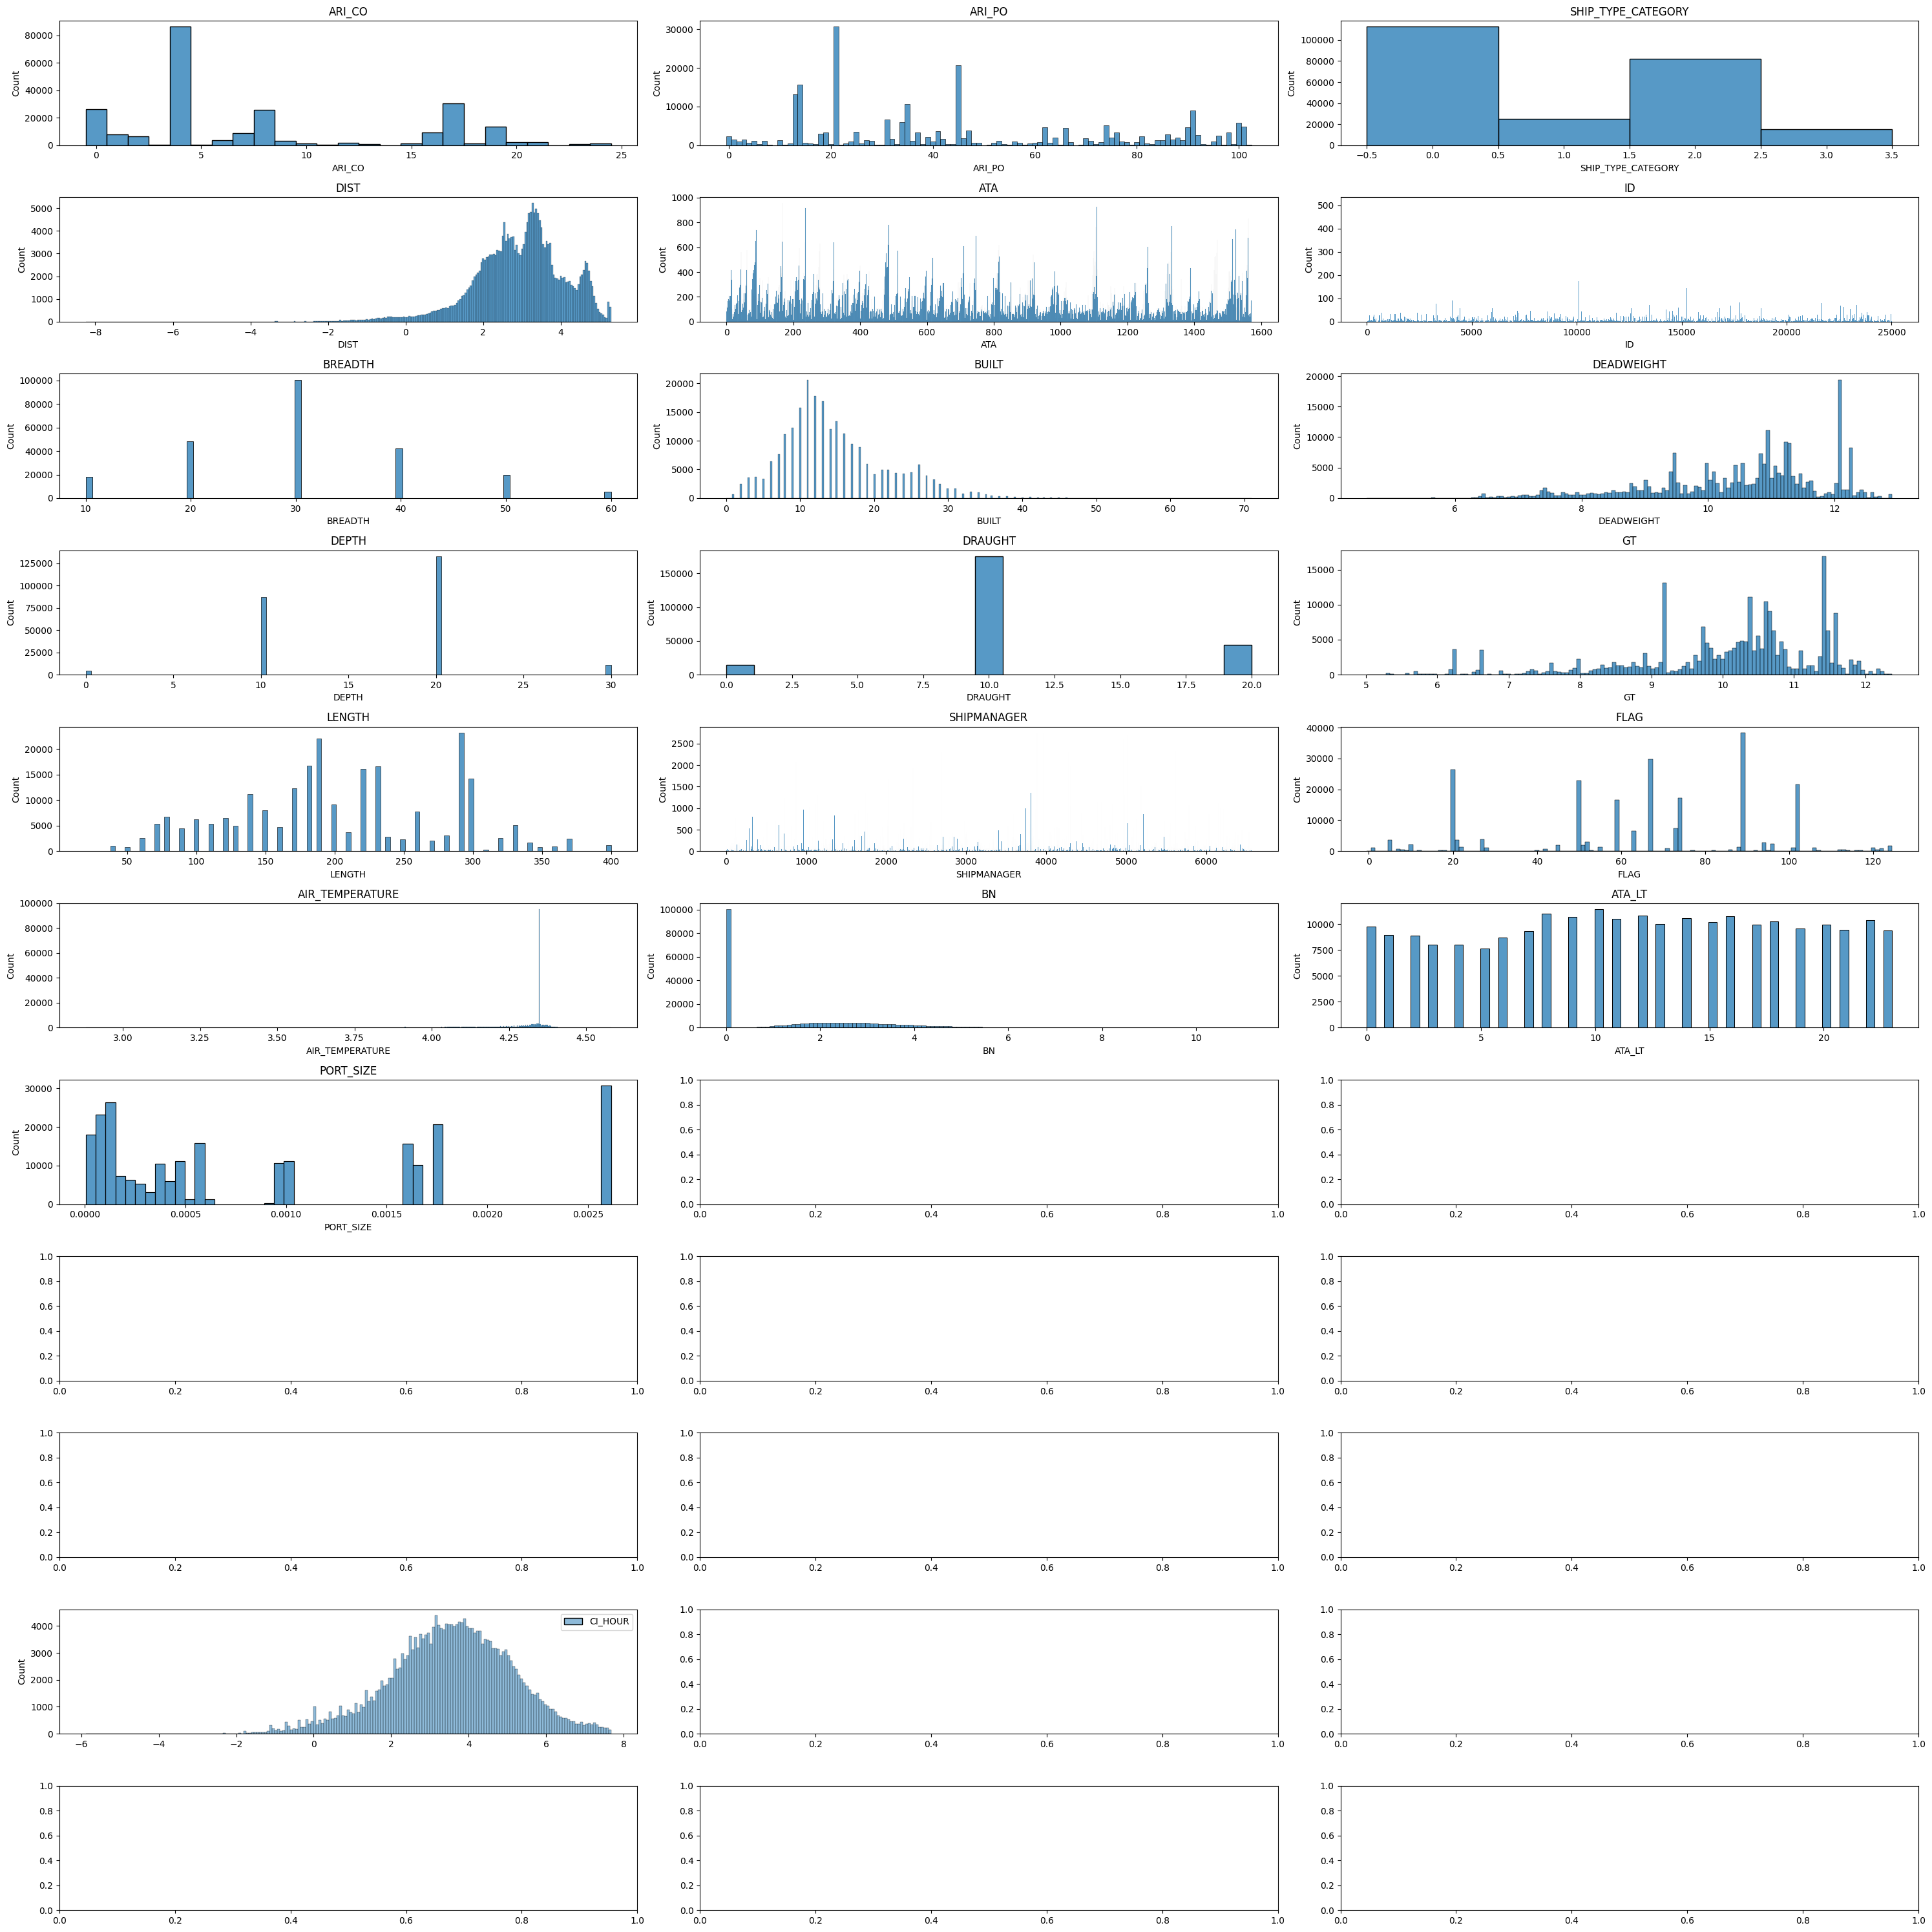

In [ ]:
import seaborn as sns
f, axes = plt.subplots(11,3)
f.set_size_inches((30,30))
col_list = X_train_nz_final.columns.tolist()
for i in range(len(col_list)):
    cur_ax = axes[i//3, i%3]
    cur_ax.set_title(col_list[i])
    sns.histplot(data=X_train_nz_final[col_list[i]],ax = cur_ax)
sns.histplot(data=Y_train_nz_final,ax = axes[9,0])
plt.tight_layout()

In [ ]:
print(Y_train_nz_final)

         CI_HOUR
0       1.238374
1       5.535579
2       4.225247
3       3.456334
4       4.063766
...          ...
234641  4.498522
234642  6.999055
234643  4.970240
234644  3.725265
234645  2.012938

[234646 rows x 1 columns]


In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
lgbm_parameter_bounds = {
    'n_estimators' : (100, 25000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 5000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 250000),
    'reg_lambda': (0, 100),
    'reg_alpha': (0, 100),
    'subsample_freq' : (0, 10)
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha, subsample_freq):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'subsample_freq' : int(round(subsample_freq)),
      'verbose' : -1,
      'num_threads' : 4,
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)

  seed = 777
  X_tr, X_test, Y_tr, Y_test=train_test_split(X_train_reduced,Y_train_nz_final,test_size=0.2, random_state=seed)

  lgbm.fit(X_tr, Y_tr)

  val_pred = lgbm.predict(X_test)
  scores = (mean_absolute_error(Y_test, val_pred))
  score = 1 / scores

  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 777)
BO_lgbm.maximize(init_points = 40, n_iter = 60)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample | subsam... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9264    | 0.5763    | 0.3093    | 1.552e+04 | 23.53     | 836.9     | 463.6     | 1.82e+04  | 3.845e+03 | 26.92     | 64.4      | 0.5467    | 0.7969    |
| 2         | 0.9033    | 0.7948    | 0.3499    | 2.472e+05 | 31.7      | 685.0     | 276.6     | 6.795e+03 | 1.873e+03 | 22.29     | 18.64     | 0.6953    | 1.932     |
| 3         | 0.9605    | 0.8055    | 0.884     | 1.556e+05 | 13.4      | 188.1     | 408.4     | 5.712e+03 | 2.589e+03 | 51.85     | 60.04     | 0.7663    | 0.1331    |
| 4         | 0.8797    | 0.762     | 0.8969    | 1.925e+05 | 7.02      | 302.9     | 306.4     | 1.818e+04 | 2.323e+03 | 76.91     | 19.16     | 0.77

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2912
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 26
[LightGBM] [Info] Start training from score 2.163316


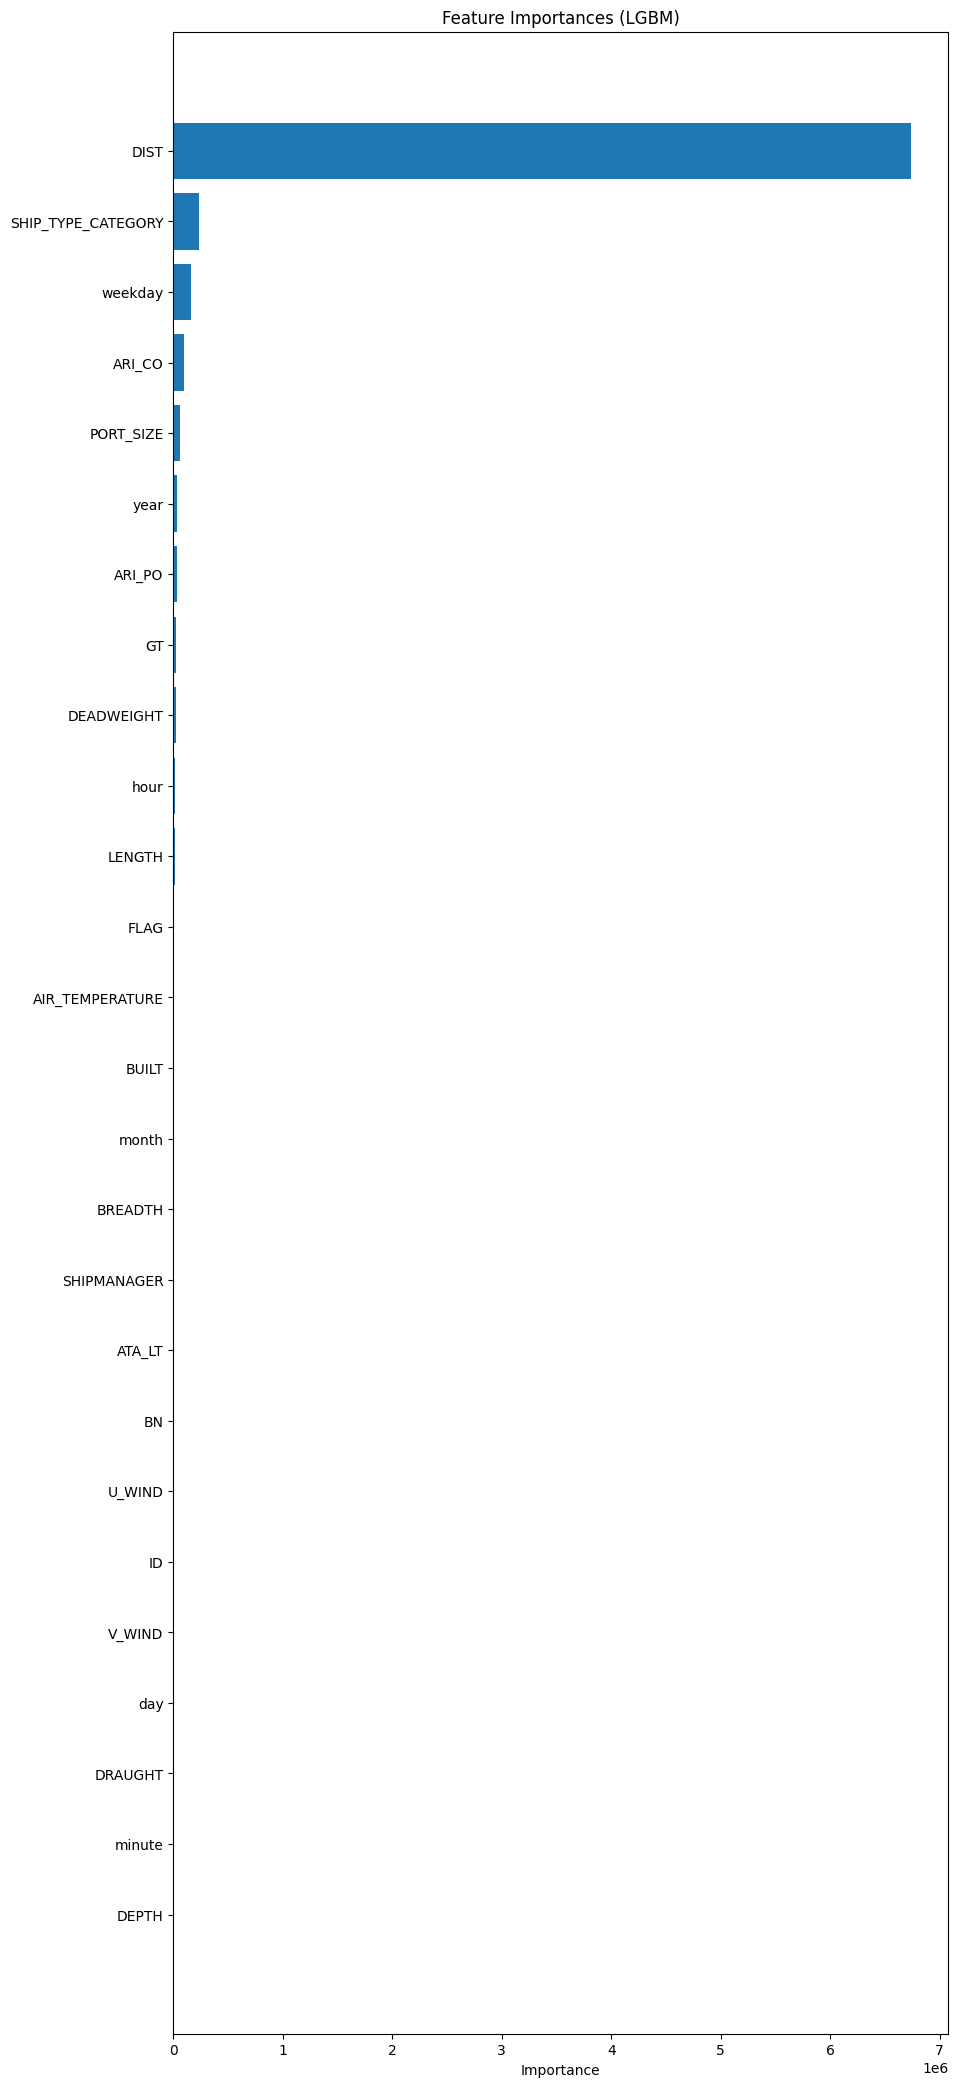

In [ ]:
# lgbm with gain and basic

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
# bayesian optimizer

!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

train = pd.read_csv('/content/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('/content/test.csv').drop(columns=['SAMPLE_ID'])

# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR'] + 1

Y_train_log = list(np.log(y_train))
Y_train_nz_data = {'CI_HOUR':Y_train_log}
Y_train_final = pd.DataFrame(Y_train_nz_data)

def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(importance_type = 'gain'), 'LGBM', X_train, Y_train_final)

In [ ]:
threshold = 0.01e6
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)


In [ ]:
print(X_train_reduced)

        ARI_CO  ARI_PO  SHIP_TYPE_CATEGORY       DIST  DEADWEIGHT      GT  \
0           17      21                   2  30.881018       24300   16700   
1            7      81                   0   0.000000       35900   23500   
2            4      14                   2   0.000000      146000  140000   
3            8     101                   2   0.000000        6910    5400   
4           17      21                   2  27.037650      116000   96600   
...        ...     ...                 ...        ...         ...     ...   
391934       8      66                   2   0.000000        6820    4820   
391935      17      21                   0   5.884603        3160    1600   
391936      21      61                   0  70.660241       60300   34800   
391937      19      35                   2   9.448179       23800   16900   
391938      19      35                   2   0.000000       50600   40200   

        LENGTH  PORT_SIZE  year  hour  weekday  
0        180.0   0.002615 

In [ ]:
lgbm_parameter_bounds = {
    'n_estimators' : (100, 50000),
    'max_depth' : (1, 50),
    'subsample' : (0.5, 1),
    'learning_rate' : (0.01, 1),
    'num_leaves' : (10, 5000),
    'colsample_bytree' : (0.5, 1),
    'min_child_samples': (10, 1000),
    'min_child_weight': (1, 500),
    'max_bin': (10, 500000),
    'reg_lambda': (0.001, 500),
    'reg_alpha': (0.01, 1000),
    }

def lgbm_bo(n_estimators,max_depth, subsample, learning_rate, num_leaves, colsample_bytree,
            min_child_samples, min_child_weight, max_bin, reg_lambda, reg_alpha):
  lgbm_params = {
      'n_estimators' : int(round(n_estimators)),
      'max_depth' : int(round(max_depth)),
      'subsample' : max(min(subsample, 1), 0),
      'learning_rate' : max(min(learning_rate, 1), 0),
      'num_leaves' : int(round(num_leaves)),
      'colsample_bytree' : max(min(colsample_bytree, 1), 0),
      'min_child_samples' : int(round(min_child_samples)),
      'min_child_weight' : int(round(min_child_weight)),
      'max_bin' : int(round(max_bin)),
      'reg_lambda' : max(reg_lambda, 0),
      'reg_alpha' : max(reg_alpha, 0),
      'verbose' : -1,
      'num_threads' : 4
      }

  lgbm = lgb.LGBMRegressor(**lgbm_params)

  seed = 777
  X_tr, X_test, Y_tr, Y_test=train_test_split(X_train_reduced,Y_train_final,test_size=0.2, random_state=seed)

  lgbm.fit(X_tr, Y_tr)

  val_pred = lgbm.predict(X_test)
  scores = (mean_absolute_error(Y_test, val_pred))
  score = 1 / scores

  return score

BO_lgbm = BayesianOptimization(f = lgbm_bo, pbounds = lgbm_parameter_bounds, random_state = 0)
BO_lgbm.maximize(init_points = 20, n_iter = 40)

# JAVASCRIPT CODE
#function ClickConnect(){
    #console.log("코랩 연결 끊김 방지");
    #document.querySelector("colab-toolbar-button#connect").click()
#}
#setInterval(ClickConnect, 60 * 1000)

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 1.63      | 0.7744    | 0.718     | 3.014e+05 | 27.7      | 429.4     | 323.3     | 2.194e+04 | 4.46e+03  | 963.7     | 191.7     | 0.8959    |
| 2         | 1.637     | 0.7644    | 0.5724    | 4.628e+05 | 4.481     | 96.26     | 11.09     | 4.165e+04 | 3.893e+03 | 870.0     | 489.3     | 0.8996    |
| 3         | 1.668     | 0.7307    | 0.7827    | 5.915e+04 | 32.36     | 151.9     | 472.4     | 2.614e+04 | 2.079e+03 | 264.6     | 387.1     | 0.7281    |
| 4         | 1.785     | 0.7842    | 0.0286    | 3.088e+05 | 30.99     | 620.8     | 471.9     | 3.412e+04 | 1.804e+03 | 437.0     | 348.8     | 0.5301    |
| 5         | 1.645     | 0.8334    | 0.6739    | 1.

KeyboardInterrupt: ignored

In [ ]:
lgbm_params = {
    'n_estimators' : 2811,
    'max_depth' : 37,
    'subsample' : 0.612,
    'learning_rate' : 0.0216,
    'num_leaves' : 1008,
    'colsample_bytree' : 0.9279,
    'min_child_samples': 180,
    'min_child_weight': 261,
    'max_bin': 180000,
    'reg_lambda': 396.8,
    'reg_alpha': 18.53,
    'verbose' : -1,
    'num_threads' : 4
    }
lgbm = lgb.LGBMRegressor(**lgbm_params)
#seed = 777
#X_tr, X_test, Y_tr, Y_test=train_test_split(X_train_reduced,Y_train_nz_final,test_size=0.2, random_state=seed)
#catm.fit(X_tr, Y_tr)
#catm_pred = catm.predict(X_test_reduced)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = Y_train_final.iloc[train_idx], Y_train_final.iloc[val_idx]

    lgbm.fit(X_t, y_t)
    val_pred = lgbm.predict(X_val)
    scores.append(mean_absolute_error(y_val, val_pred))
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    ensemble_predictions.append(lgbm_pred)

final_predictions = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds: 100%|██████████| 5/5 [1:29:20<00:00, 1072.10s/it]

Validation : MAE scores for each fold: [0.5032657044919386, 0.5112804296398261, 0.504573711923893, 0.5080558873451264, 0.5051559980723086]
Validation : MAE: 0.5064663462946186


In [ ]:
submit = pd.read_csv('/content/sample_submission.csv')
lgbm_pred_df = pd.DataFrame(final_predictions)
pred_after_list = list(np.exp(lgbm_pred_df)[0] - 1)

data_result = {'SAMPLE_ID' : list(submit['SAMPLE_ID']), 'CI_HOUR' : pred_after_list}

result = pd.DataFrame(data_result)
result.to_csv('submission_final_lgb.csv', index=False)